**__Описание:__**

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и 
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время.

**__Цель__**

Предсказать вероятность покупки в течение 90 дней

**__Задачи__**

- Изучить данные
- Разработать полезные признаки
- Создать модель для классификации пользователей
- Улучшить модель и максимизировать метрику roc_auc
- Выполнить тестирование

**__Данные__**

`apparel-purchases` - история покупок

- client_id идентификатор пользователя
- quantity количество товаров в заказе
- price цена товара
- category_ids вложенные категории, к которым отнсится товар
- date дата покупки
- message_id идентификатор сообщения из рассылки

`apparel-messages` - история рекламных рассылок

- bulk_campaign_id идентификатор рекламной кампании
- client_id идентификатор пользователя
- message_id идентификатор сообщений
- event тип действия
- channel канал рассылки
- date дата рассылки
- created_at точное время создания сообщения

`apparel-target_binary` - совершит ли клиент покупку в течение следующих 90 дней

- client_id идентификатор пользователя
- target целевой признак

In [286]:
import pandas as pd 
import numpy as np 
import statsmodels.api as sm


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from category_encoders import TargetEncoder


from sklearn.model_selection import train_test_split, KFold, GridSearchCV 
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import phik 

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                             precision_score, recall_score, confusion_matrix,
                             PrecisionRecallDisplay, RocCurveDisplay)
from sklearn.utils.class_weight import compute_sample_weight
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
# from sklearn.ensemble import RandomForestClassifier


from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, make_scorer,  precision_recall_curve


from sklearn.dummy import DummyClassifier

from sklearn.base import BaseEstimator, TransformerMixin
import ast

from ydata_profiling import ProfileReport

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [292]:
!pipreqs -print

Usage:
    pipreqs [options] [<path>]


# 1. Загрузка и предварительная очистка

In [3]:
df_messages = pd.read_csv('filtered_data/apparel-messages.csv') # Рекламная рассылка
df_purchases = pd.read_csv('filtered_data/apparel-purchases.csv') # Это покупки
df_target = pd.read_csv('filtered_data/apparel-target_binary.csv') # Это таргет 
# df_daily = pd.read_csv('filtered_data/full_campaign_daily_event.csv')
# df_channel = pd.read_csv('filtered_data/full_campaign_daily_event_channel.csv')

In [4]:
print(df_messages.info(), df_purchases.info(), df_target.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB
<class 'pandas.core.frame.DataFrame'>
Ra

In [5]:
idx_client = df_target.client_id.unique().tolist()
print(len(idx_client))
idx_purchare = df_purchases.query('client_id in @idx_client')['client_id'].unique().tolist()
print(len(idx_client))
idx_messages = df_messages.query('client_id in @idx_client')['client_id'].unique().tolist()
print(len(idx_messages))

49849
49849
41982


Количество уникальных клиентов в целевой 49849, реклама приходила не всем пользователям 

- Количество уникальных пользователей в `df_purchases` совпадает с количеством уникальных пользователей в `df_target`
- А датафрейм с рассылками `df_messages` содержит  не всех пользователей у которых были покупки 

## 1.1 Предобработка дат и категорий 

In [6]:
# Преобразование дат
df_messages['date'] = pd.to_datetime(df_messages['date'])
df_messages['created_at'] = pd.to_datetime(df_messages['created_at'])
df_purchases['date'] = pd.to_datetime(df_purchases['date'])

# Распарсить category_ids
df_purchases['category_ids'] = df_purchases['category_ids'].apply(ast.literal_eval)

# Посмотреть первые строки

print(f"{df_purchases.shape}, Покупки:\n {df_purchases.head()}\n {'#'*30}")
print(f"{df_messages.shape} Рассылки:\n {df_messages.head()}\n {'#'*30}")
print(f"{df_target.shape} Таргет:\n {df_target.head()}\n {'#'*30}", )

(202208, 6), Покупки:
              client_id  quantity   price       category_ids       date  \
0  1515915625468169594         1  1999.0   [4, 28, 57, 431] 2022-05-16   
1  1515915625468169594         1  2499.0   [4, 28, 57, 431] 2022-05-16   
2  1515915625471138230         1  6499.0   [4, 28, 57, 431] 2022-05-16   
3  1515915625471138230         1  4999.0  [4, 28, 244, 432] 2022-05-16   
4  1515915625471138230         1  4999.0   [4, 28, 49, 413] 2022-05-16   

                               message_id  
0  1515915625468169594-4301-627b661e9736d  
1  1515915625468169594-4301-627b661e9736d  
2  1515915625471138230-4437-6282242f27843  
3  1515915625471138230-4437-6282242f27843  
4  1515915625471138230-4437-6282242f27843  
 ##############################
(12739798, 7) Рассылки:
    bulk_campaign_id            client_id  \
0              4439  1515915625626736623   
1              4439  1515915625490086521   
2              4439  1515915625553578558   
3              4439  15159156255535

## 1.2 Базовый разбор категорий покупок и удаление дубликатов

In [7]:
df_purchases['len_cat'] = df_purchases.category_ids.apply(lambda x : len(x))

In [8]:
df_purchases['len_cat'].unique()

array([4, 5, 1, 0, 3])

In [9]:
for cat in df_purchases['len_cat'].unique(): 
    result = df_purchases[df_purchases['len_cat'] == cat].category_ids.astype('str')
    print(f"Количество уникальных категорий в длине `{cat}`: {result.nunique()}, их количество - {len(result)}")

Количество уникальных категорий в длине `4`: 908, их количество - 193491
Количество уникальных категорий в длине `5`: 1, их количество - 518
Количество уникальных категорий в длине `1`: 1, их количество - 1264
Количество уникальных категорий в длине `0`: 1, их количество - 5579
Количество уникальных категорий в длине `3`: 22, их количество - 1356


Рассмотрим одиночные категории 

In [10]:
print(df_purchases[df_purchases['len_cat'] == 1].category_ids.iloc[0])
print(df_purchases[df_purchases['len_cat'] == 0].category_ids.iloc[0])
print(df_purchases[df_purchases['len_cat'] == 5].category_ids.iloc[0])
print(df_purchases[df_purchases['len_cat'] == 3].category_ids.astype('str').unique())

[None]
[]
['2', '17', '330', '387', '467']
["['4', '44', '428']" "['4', '44', '1594']" "['4', '44', '989']"
 "['4', '44', '489']" "['4', '44', '430']" "['4', '44', '501']"
 "['4', '44', '491']" "['4', '44', '1097']" "['4', '44', '490']"
 "['4', '44', '493']" "['4', '44', '1571']" "['4', '44', '549']"
 "['4', '1822', '499']" "['4', '30', '503']" "['4', '44', '1564']"
 "['4', '44', '492']" "['4', '44', '528']" "['4', '44', '1381']"
 "['4', '44', '494']" "['4', '44', '1600']" "['5562', '5597', '5782']"
 "['4', '29', '503']"]


In [11]:
# Фильтруем только те строки, где len_cat == 4
df_filtered = df_purchases[df_purchases['len_cat'] == 4]

# Получаем списки категорий
categories = df_filtered['category_ids']

# Считаем количество уникальных значений для каждого индекса в списке (0, 1, 2, 3)
for i in range(4):
    unique_values = sorted(set(cat[i] for cat in categories))
    print(f"Позиция {i+1} (индекс {i}): {len(unique_values)} уникальных значений")
    print(f"Примеры: {list(unique_values)[:10]}")

Позиция 1 (индекс 0): 8 уникальных значений
Примеры: ['1', '2', '3', '4', '5', '5562', '5963', '6060']
Позиция 2 (индекс 1): 30 уникальных значений
Примеры: ['10', '12', '14', '17', '18', '1822', '22', '27', '28', '29']
Позиция 3 (индекс 2): 269 уникальных значений
Примеры: ['104', '105', '107', '108', '123', '124', '137', '138', '142', '146']
Позиция 4 (индекс 3): 837 уникальных значений
Примеры: ['1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010']


- Итого категория `None`, `[]` можно отнести к одной группе, группа с 5-ым уровнем вложености одно уникальное значение, создадим на основе этого бинарные признаки.
- Создадим для первой позиции в категории 4-и также бинарные признаки, для первых восьми категорий (['4', '2', '5562', '1', '3', '6060', '5', '5963']).

In [12]:
# Группа первая для детализации заказов в 4 категории  
group_one = ['4', '2', '5562', '1', '3', '6060', '5', '5963'] 
cols_cat_group = []  

# Создание 8-ми бинарных колонок для самой многочисленной группы 
for one_cat in group_one: 
    col_name = f'is_cat_four_is_{one_cat}'
    cols_cat_group.append(col_name)
    df_purchases[col_name] = df_purchases['category_ids'].apply(
        lambda x: 1 if isinstance(x, (list, tuple)) and len(x) == 4 and str(x[0]) == one_cat else 0
    )
    #df_purchases['category_ids'].apply(lambda x: 1 if len(x) == 4 and str(x[0]) == one_cat else 0 )
    
# Создание для редких групп 
df_purchases['is_cat_five'] = (df_purchases['len_cat'] == 5).astype(int)
df_purchases['is_cat_one_or_zero'] = ((df_purchases['len_cat'] == 0) | (df_purchases['len_cat'] == 1)).astype(int)
df_purchases['is_cat_three'] = (df_purchases['len_cat'] == 3).astype(int)

# Добавление имен колонок, для дальнейшего анализа 
cols_cat_group.append('is_cat_five')
cols_cat_group.append('is_cat_one_or_zero')
cols_cat_group.append('is_cat_three')

# Посмотрим на количество в каждой крупной категориии 

for cat in cols_cat_group: 
    print(f"Колонка {cat}, количество покупок: {df_purchases[cat].sum()} ")

Колонка is_cat_four_is_4, количество покупок: 111236 
Колонка is_cat_four_is_2, количество покупок: 26911 
Колонка is_cat_four_is_5562, количество покупок: 46497 
Колонка is_cat_four_is_1, количество покупок: 3 
Колонка is_cat_four_is_3, количество покупок: 11 
Колонка is_cat_four_is_6060, количество покупок: 7559 
Колонка is_cat_four_is_5, количество покупок: 2 
Колонка is_cat_four_is_5963, количество покупок: 1272 
Колонка is_cat_five, количество покупок: 518 
Колонка is_cat_one_or_zero, количество покупок: 6843 
Колонка is_cat_three, количество покупок: 1356 


In [13]:
print(df_messages.isna().mean() * 100, df_purchases.isna().mean() * 100, df_target.isna().mean() * 100)

bulk_campaign_id    0.0
client_id           0.0
message_id          0.0
event               0.0
channel             0.0
date                0.0
created_at          0.0
dtype: float64 client_id              0.0
quantity               0.0
price                  0.0
category_ids           0.0
date                   0.0
message_id             0.0
len_cat                0.0
is_cat_four_is_4       0.0
is_cat_four_is_2       0.0
is_cat_four_is_5562    0.0
is_cat_four_is_1       0.0
is_cat_four_is_3       0.0
is_cat_four_is_6060    0.0
is_cat_four_is_5       0.0
is_cat_four_is_5963    0.0
is_cat_five            0.0
is_cat_one_or_zero     0.0
is_cat_three           0.0
dtype: float64 client_id    0.0
target       0.0
dtype: float64


Пропусков нету это хорошо, посмотрим дубликаты 

In [14]:
df_purchases['list_cat_as_str'] = df_purchases['category_ids'].apply(lambda x: str(x))

In [15]:
df_purchases.columns

Index(['client_id', 'quantity', 'price', 'category_ids', 'date', 'message_id',
       'len_cat', 'is_cat_four_is_4', 'is_cat_four_is_2',
       'is_cat_four_is_5562', 'is_cat_four_is_1', 'is_cat_four_is_3',
       'is_cat_four_is_6060', 'is_cat_four_is_5', 'is_cat_four_is_5963',
       'is_cat_five', 'is_cat_one_or_zero', 'is_cat_three', 'list_cat_as_str'],
      dtype='object')

Уберем category_ids

In [16]:
df_purchases.drop(columns=['category_ids'], axis=1, inplace=True)

In [17]:
# purs_cols_withot_list_cat = ['client_id', 'quantity', 'price', 'date', 'message_id',
#        'len_cat', 'is_cat_four_is_4', 'is_cat_four_is_2',
#        'is_cat_four_is_5562', 'is_cat_four_is_1', 'is_cat_four_is_3',
#        'is_cat_four_is_6060', 'is_cat_four_is_5', 'is_cat_four_is_5963',
#        'is_cat_five', 'is_cat_one_or_zero', 'is_cat_three', 'list_cat_as_str']

In [18]:
print(df_target.duplicated().sum(), df_messages.duplicated().sum(), df_purchases.duplicated().sum())

0 48610 73020


In [19]:
df_purchases_clear = df_purchases.drop_duplicates().reset_index(drop=['index'])
df_messages_clear = df_messages.drop_duplicates().reset_index(drop=['index'])

In [20]:
print(df_purchases_clear.info(), df_messages_clear.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129188 entries, 0 to 129187
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   client_id            129188 non-null  int64         
 1   quantity             129188 non-null  int64         
 2   price                129188 non-null  float64       
 3   date                 129188 non-null  datetime64[ns]
 4   message_id           129188 non-null  object        
 5   len_cat              129188 non-null  int64         
 6   is_cat_four_is_4     129188 non-null  int64         
 7   is_cat_four_is_2     129188 non-null  int64         
 8   is_cat_four_is_5562  129188 non-null  int64         
 9   is_cat_four_is_1     129188 non-null  int64         
 10  is_cat_four_is_3     129188 non-null  int64         
 11  is_cat_four_is_6060  129188 non-null  int64         
 12  is_cat_four_is_5     129188 non-null  int64         
 13  is_cat_four_is

In [21]:
print(df_messages_clear.shape, df_purchases_clear.shape)

(12691188, 7) (129188, 18)


In [22]:
len(df_messages_clear.query('client_id not in @idx_client'))

1777991

In [23]:
len(df_messages_clear.query('client_id in @idx_client'))

10913197

Перед объеденением создадим признаки описывающие покупки 

## 1.3 Создание признаков для `df_purchases`

In [24]:
# Количество покупок у пользователя 
df_purchases_clear['purchase_count'] = df_purchases_clear.groupby('client_id')['client_id'].transform('count')

In [25]:
# Общая сумма едениц товара у пользователя 

group_sum_purch = df_purchases_clear.groupby('client_id')['price'].agg('sum').reset_index(name='sum_price')
df_purchases_clear = df_purchases_clear.merge(group_sum_purch, on='client_id', how='left')

In [26]:
# Общее количество товаров у клиента

group_quant_purch = df_purchases_clear.groupby('client_id')['quantity'].agg('sum').reset_index(name='sum_quant')
df_purchases_clear = df_purchases_clear.merge(group_quant_purch, on='client_id', how='left')

In [27]:
# Первая и последняя покупка для каждого клиента

date_minmax = df_purchases_clear.groupby('client_id')['date'].agg(['min', 'max']).reset_index()
date_minmax.columns = ['client_id', 'date_min_purch', 'date_max_purch']
df_purchases_clear = df_purchases_clear.merge(date_minmax, on='client_id', how='left')

In [28]:
# Средний интервал между покупками 

def mean_days_between_purchases(x):
    x = pd.to_datetime(sorted(x))
    if len(x) < 2:
        return None
    return (x[1:] - x[:-1]).mean().days

mean_interval = df_purchases_clear.groupby('client_id')['date'].agg(mean_days_between_purchases).reset_index(name='mean_days_between_purchases').fillna(0)
df_purchases_clear = df_purchases_clear.merge(mean_interval, on='client_id', how='left')

In [29]:
# Уникальные категории покупок клиентов

def unique_cats(list_of_cats):
    flat = [item for sublist in list_of_cats for item in sublist]
    return len(set(flat))

unique_cats_count = df_purchases_clear.groupby('client_id')['list_cat_as_str'].agg(unique_cats).reset_index(name='unique_cats_count')
df_purchases_clear = df_purchases_clear.merge(unique_cats_count, on='client_id', how='left')

In [30]:
# Покупал ли в каждой категории клиент 

cat_cols = [c for c in df_purchases_clear.columns if c.startswith('is_cat_four_is_') or c.startswith('is_cat_')]
df_purchases_clear['cat_variety'] = df_purchases_clear[cat_cols].sum(axis=1)
cat_variety = df_purchases_clear.groupby('client_id')[cat_cols].sum()
cat_variety['cat_variety_count'] = (cat_variety > 0).sum(axis=1)
cat_variety = cat_variety[['cat_variety_count']].reset_index()
df_purchases_clear = df_purchases_clear.merge(cat_variety, on='client_id', how='left')

df_purchases_clear.drop(columns=['cat_variety'], axis=1, inplace=True)

In [31]:
# Бинарный признак повторный ли покупатель 

repeat_buyer = df_purchases_clear.groupby('client_id').size().reset_index(name='purchase_count')
repeat_buyer['is_repeat_buyer'] = (repeat_buyer['purchase_count'] > 1).astype(int)
df_purchases_clear = df_purchases_clear.merge(repeat_buyer[['client_id', 'is_repeat_buyer']], on='client_id', how='left')

In [32]:
# Время в днях между первой и последней покупками

date_minmax['lifetime_days'] = (pd.to_datetime(date_minmax['date_max_purch']) - pd.to_datetime(date_minmax['date_min_purch'])).dt.days
df_purchases_clear = df_purchases_clear.merge(date_minmax[['client_id', 'lifetime_days']], on='client_id', how='left')

In [33]:
df_purchases_clear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129188 entries, 0 to 129187
Data columns (total 28 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   client_id                    129188 non-null  int64         
 1   quantity                     129188 non-null  int64         
 2   price                        129188 non-null  float64       
 3   date                         129188 non-null  datetime64[ns]
 4   message_id                   129188 non-null  object        
 5   len_cat                      129188 non-null  int64         
 6   is_cat_four_is_4             129188 non-null  int64         
 7   is_cat_four_is_2             129188 non-null  int64         
 8   is_cat_four_is_5562          129188 non-null  int64         
 9   is_cat_four_is_1             129188 non-null  int64         
 10  is_cat_four_is_3             129188 non-null  int64         
 11  is_cat_four_is_6060       

In [34]:
cols_feature_purchases_to_merge = ['len_cat', 'message_id', 'date', 'purchase_count', 'sum_price', 'sum_quant', 'date_min_purch',
       'date_max_purch', 'mean_days_between_purchases', 'unique_cats_count',
       'cat_variety_count', 'is_repeat_buyer', 'lifetime_days']

## 1.4 Удаление дубликатов из `df_purchases` и объеденене с `df_target`

In [35]:
df_purchases_feature = df_purchases_clear[['client_id'] + cols_feature_purchases_to_merge].drop_duplicates('client_id', keep='first').reset_index(drop=['index'])

In [36]:
df_purchases_feature.head(3)

client_id  len_cat                              message_id  \
0  1515915625468169594        4  1515915625468169594-4301-627b661e9736d   
1  1515915625471138230        4  1515915625471138230-4437-6282242f27843   
2  1515915625471640575        4  1515915625471640575-4301-627b661b67ac3   

        date  purchase_count  sum_price  sum_quant date_min_purch  \
0 2022-05-16               8    19013.0          8     2022-05-16   
1 2022-05-16               3    16497.0          3     2022-05-16   
2 2022-05-16               3     5797.0          3     2022-05-16   

  date_max_purch  mean_days_between_purchases  unique_cats_count  \
0     2023-11-22                         79.0                 15   
1     2022-05-16                          0.0                 13   
2     2022-06-17                         16.0                 12   

   cat_variety_count  is_repeat_buyer  lifetime_days  
0                  2                1            555  
1                  1                1              0  
2                  1                1             32

In [37]:
df_purchases_feature.shape

(49849, 14)

In [38]:
df_merge = df_target.merge(df_purchases_feature, 
                          on='client_id', 
                          how='left'
                         )
df_merge.shape

(49849, 15)

## 1.5 Очистка `df_messages` и объеденение с `target`

Оставляем в `df_messages_clear` только идентификаторы которые присутствуют в `df_target`

In [39]:
df_messages_clear = df_messages_clear.query('client_id in @idx_client')

In [40]:
df_messages_clear.sample(1)

bulk_campaign_id            client_id  \
2145036              7442  1515915625468080751   

                                     message_id event      channel       date  \
2145036  1515915625468080751-7442-635a95f63fcd7  send  mobile_push 2022-10-27   

                 created_at  
2145036 2022-10-27 14:30:17

In [41]:
# Получаем минимальную и максимальную дату для каждого client_id
date_range = df_messages_clear.groupby('client_id')['date'].agg(['min', 'max']).reset_index()

# Считаем количество уникальных месяцев
date_range['months'] = ((date_range['max'].dt.year - date_range['min'].dt.year) * 12 +
                        (date_range['max'].dt.month - date_range['min'].dt.month) + 1)

In [42]:
msg_counts = df_messages_clear.groupby('client_id').size().reset_index(name='total_ads')

In [43]:
# Мержим месяцы и сообщения

merged = msg_counts.merge(date_range[['client_id', 'months']], on='client_id', how='left')
merged['ads_per_month'] = merged['total_ads'] / merged['months']

In [44]:
df_messages_clear = df_messages_clear.merge(merged[['client_id', 'ads_per_month']], on='client_id', how='left')

In [45]:
df_messages_clear['event_count'] = df_messages_clear.groupby('client_id')['client_id'].transform('count')
event_counts = df_messages_clear.groupby(['client_id', 'event']).size().unstack(fill_value=0)
# event_counts будет DataFrame с колонками open, click, ... и индексом client_id

# Мержим эти данные обратно в исходный датафрейм
df_messages_clear = df_messages_clear.merge(event_counts, on='client_id', how='left')

In [46]:
channel_counts = df_messages_clear.groupby(['client_id', 'channel']).size().unstack(fill_value=0)
df_messages_clear = df_messages_clear.merge(channel_counts, on='client_id', how='left')

In [47]:
df_messages_clear.sample(3)

bulk_campaign_id            client_id  \
677914               5455  1515915625560389685   
2275477              7882  1515915625488529414   
2282802              7882  1515915625585061657   

                                     message_id event      channel       date  \
677914   1515915625560389685-5455-62d016e16f145  send  mobile_push 2022-07-14   
2275477  1515915625488529414-7882-637397eb0bdb2  send  mobile_push 2022-11-15   
2282802  1515915625585061657-7882-637397ee1737f  send  mobile_push 2022-11-15   

                 created_at  ads_per_month  event_count  click  close  \
677914  2022-07-14 13:20:19       9.181818          202      7      0   
2275477 2022-11-15 13:48:43      25.000000          550      6      0   
2282802 2022-11-15 14:10:25      11.318182          249     13      0   

         complain  hard_bounce  hbq_spam  open  purchase  send  soft_bounce  \
677914          0            0         0     0         1   194            0   
2275477         0            0         0   163         1   380            0   
2282802         0            0         0     0         1   235            0   

         subscribe  unsubscribe  email  mobile_push  
677914           0            0      0          202  
2275477          0            0    192          358  
2282802          0            0      0          249

In [48]:
print(df_merge.columns, df_messages_clear.columns)

Index(['client_id', 'target', 'len_cat', 'message_id', 'date',
       'purchase_count', 'sum_price', 'sum_quant', 'date_min_purch',
       'date_max_purch', 'mean_days_between_purchases', 'unique_cats_count',
       'cat_variety_count', 'is_repeat_buyer', 'lifetime_days'],
      dtype='object') Index(['bulk_campaign_id', 'client_id', 'message_id', 'event', 'channel',
       'date', 'created_at', 'ads_per_month', 'event_count', 'click', 'close',
       'complain', 'hard_bounce', 'hbq_spam', 'open', 'purchase', 'send',
       'soft_bounce', 'subscribe', 'unsubscribe', 'email', 'mobile_push'],
      dtype='object')


In [49]:
msg_cols_to_add = ['bulk_campaign_id', 'client_id', 'date',
                   'created_at', 'ads_per_month', 'event_count', 'click', 'close',
                   'complain', 'hard_bounce', 'hbq_spam', 'open', 'purchase', 'send',
                   'soft_bounce', 'subscribe', 'unsubscribe', 'email', 'mobile_push']

In [50]:
# idx_msg = df_messages_clear.message_id.unique().tolist()
# idx_clients_msg = df_messages_clear.client_id.unique().tolist()

In [51]:
# idx_msg_uniq = df_purchases.query('message_id in @idx_msg & client_id in @idx_clients_msg').message_id
# len(idx_msg_uniq)

In [52]:
# df_messages_clear_cp = df_messages_clear.query('message_id in @idx_msg_uniq').copy()
# df_messages_clear_cp = df_messages_clear_cp.drop_duplicates('client_id', keep='first').reset_index(drop=['index']).copy()

In [53]:
# df_messages_clear_cp = df_messages_clear.drop_duplicates('client_id', keep='first').reset_index(drop=['index']).copy()

In [54]:
df = df_merge.merge(df_messages_clear[msg_cols_to_add],
                         on='client_id', 
                         how='left',
                         suffixes=('_purch', '_msg'))
df.shape

(10921064, 33)

In [55]:
print(df.client_id.nunique(), df.target.value_counts(), df.duplicated().sum())

49849 target
0    10648748
1      272316
Name: count, dtype: int64 61247


In [56]:
df = df.drop_duplicates().reset_index(drop=['index']).copy()

In [57]:
df.isna().mean() * 100

client_id                      0.000000
target                         0.000000
len_cat                        0.000000
message_id                     0.000000
date_purch                     0.000000
purchase_count                 0.000000
sum_price                      0.000000
sum_quant                      0.000000
date_min_purch                 0.000000
date_max_purch                 0.000000
mean_days_between_purchases    0.000000
unique_cats_count              0.000000
cat_variety_count              0.000000
is_repeat_buyer                0.000000
lifetime_days                  0.000000
bulk_campaign_id               0.072441
date_msg                       0.072441
created_at                     0.072441
ads_per_month                  0.072441
event_count                    0.072441
click                          0.072441
close                          0.072441
complain                       0.072441
hard_bounce                    0.072441
hbq_spam                       0.072441


In [58]:
df['date_msg'] = pd.to_datetime(df.date_msg)

In [59]:
df['date_msg'] = df['date_msg'].fillna(df['date_msg'].min())

In [60]:
df['diff_beetween_purch_msg'] = (df['date_purch'] - df['date_msg']).dt.days

In [61]:
idx_cl_pur_msg = df.query('date_purch > date_msg').client_id.unique()

In [62]:
df['is_purch_after_msg'] = df.client_id.isin(idx_cl_pur_msg).astype(int)

In [63]:
df = df.fillna(-99)

In [64]:
df.client_id.nunique()

49849

In [65]:
df = df.drop_duplicates('client_id', keep='first').reset_index(drop=['index']).copy()

In [66]:
df.isna().mean() * 100

client_id                      0.0
target                         0.0
len_cat                        0.0
message_id                     0.0
date_purch                     0.0
purchase_count                 0.0
sum_price                      0.0
sum_quant                      0.0
date_min_purch                 0.0
date_max_purch                 0.0
mean_days_between_purchases    0.0
unique_cats_count              0.0
cat_variety_count              0.0
is_repeat_buyer                0.0
lifetime_days                  0.0
bulk_campaign_id               0.0
date_msg                       0.0
created_at                     0.0
ads_per_month                  0.0
event_count                    0.0
click                          0.0
close                          0.0
complain                       0.0
hard_bounce                    0.0
hbq_spam                       0.0
open                           0.0
purchase                       0.0
send                           0.0
soft_bounce         

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   client_id                    49849 non-null  int64         
 1   target                       49849 non-null  int64         
 2   len_cat                      49849 non-null  int64         
 3   message_id                   49849 non-null  object        
 4   date_purch                   49849 non-null  datetime64[ns]
 5   purchase_count               49849 non-null  int64         
 6   sum_price                    49849 non-null  float64       
 7   sum_quant                    49849 non-null  int64         
 8   date_min_purch               49849 non-null  datetime64[ns]
 9   date_max_purch               49849 non-null  datetime64[ns]
 10  mean_days_between_purchases  49849 non-null  float64       
 11  unique_cats_count            49849 non-nu

## 1.6 Вывод по предварительной очистке и сиозданию признаков 

**__Уникальные значения и предобработка__**

- в `df_purchases` присутвствуют все уникальные идентификаторы которые есть в `df_target` : `49849`, с `df_messages` дела обстоят по другому всего `41982` идентификаторов клиентов которые присутствуют в `df_target`.
- категории для покупок были детализированны для обработки (`0`, `1` были отнесены по итогу к одной группе т.к. это неизвестная категория покупок): 
  1. Количество уникальных категорий в длине `5`: 1, их количество - 518
  2. Количество уникальных категорий в длине `1`: 1, их количество - 1264 ([None])
  3. Количество уникальных категорий в длине `0`: 1, их количество - 5579 ([])
  4. Количество уникальных категорий в длине `3`: 22, их количество - 1356
  5. Количество уникальных категорий в длине `4`: 908, их количество - 193491
- Также были удалены дубликаты 

**__Признаки для `df_purchases`(Покупки)__** 

- `purchase_count` - Количество покупок у пользователя.
- `sum_price` - Общая сумма на еденицу товара у клиента.
- `sum_quant` - Общее количество товаров у клиента.
- `date_min_purch`, `date_max_purch`  - Дата первой и последней покупки для каждого клиента.
- `mean_days_between_purchases` - Средний интервал между покупками.
- `unique_cats_count` - Уникальные категории покупок клиентов.
- `cat_variety_count` - Покупал ли в каждой категории клиент.
- `is_repeat_buyer` - Больше ли одной покупки у клиента.
- `lifetime_days` - Интервал в днях между первой и последней покупкой.

**__Признаки для `df_messages`(Рекламные сообщения)__** 

- `ads_per_month` - Количество рекламы полученное пользователем в месяц.
- [`event_count`, `click`, `close`,`complain`, `hard_bounce`, `hbq_spam`, `open`, `purchase`, `send`, `soft_bounce`, `subscribe`, `unsubscribe`, `email`, `mobile_push`] - Статистика по действиям пользователя при сообщения (количество кликов, количество спама и т.д.).
- `diff_beetween_purch_msg` - количество дней между сообщением о рекламе и покупке
- `is_purch_after_msg` - была ли покупка до рекламы. 

# 2. EDA Анализ

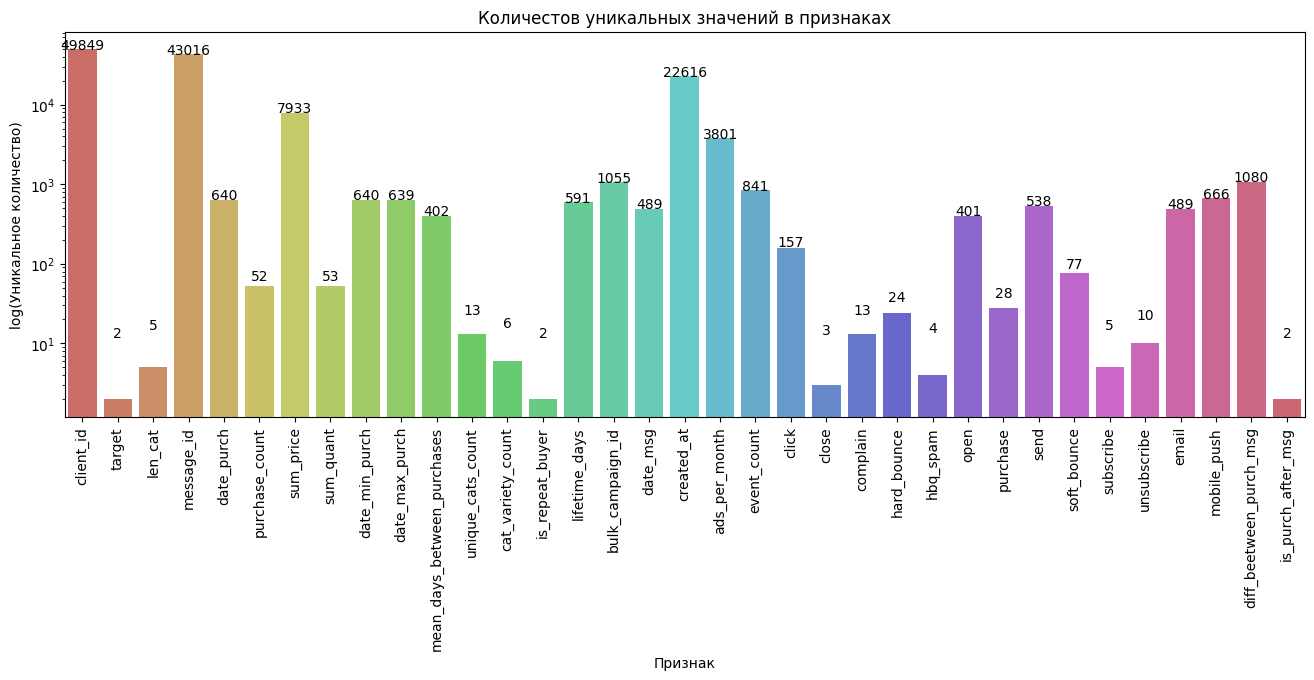

In [68]:
def plot_unique(df):
    plt.figure(figsize=(16, 5))
    
    cols = df.columns
    uniques = [len(df[col].unique()) for col in cols]
    
    ax = sns.barplot(x=cols, y=uniques, palette='hls', log=True)
    ax.set(xlabel='Признак', ylabel='log(Уникальное количество)', title='Количестов уникальных значений в признаках')
    
    
    for p, uniq in zip(ax.patches, uniques):
        ax.text(p.get_x() + p.get_width()/2.,
                uniq + 10,
                uniq,
                ha="center") 
    
    ax.set_xticklabels(ax.get_xticklabels(),  rotation=90);

plot_unique(df)

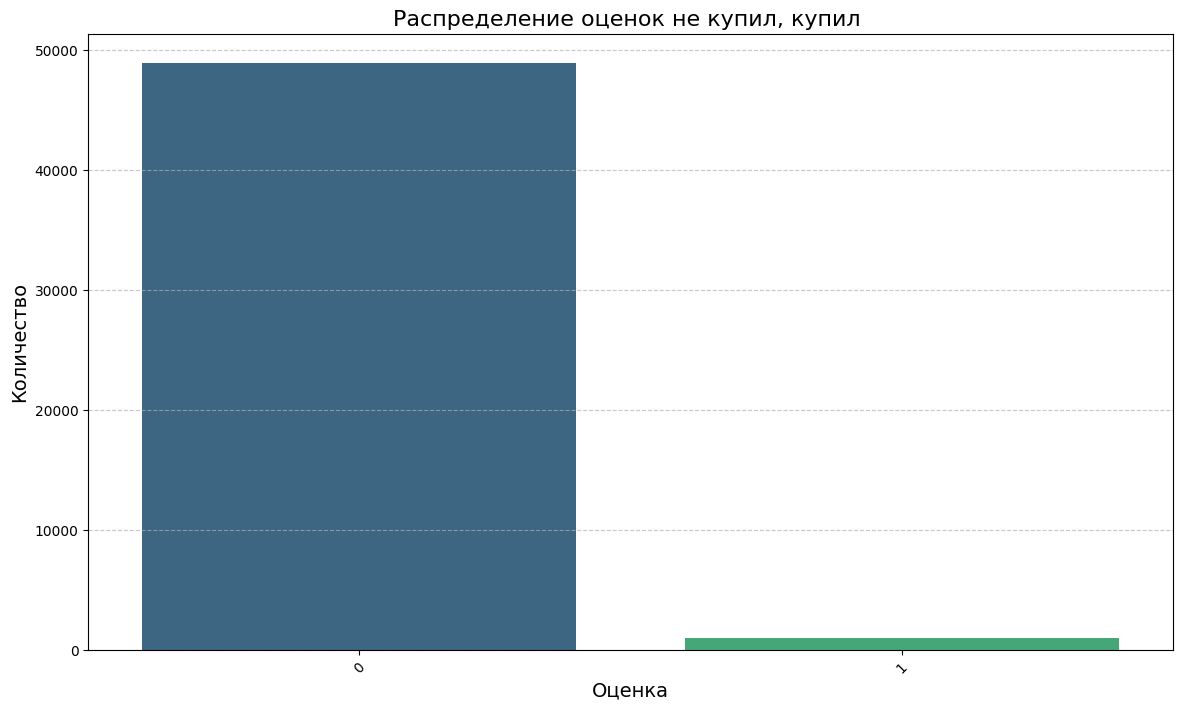

In [69]:
value_counts = df['target'].value_counts().sort_index()

# Настройка фигуры
plt.figure(figsize=(14, 8))
sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")

# Настройка графика
plt.title("Распределение оценок не купил, купил ", fontsize=16)
plt.xlabel("Оценка", fontsize=14)
plt.ylabel("Количество", fontsize=14)
plt.xticks(rotation=45)  # Поворот меток на оси X для удобства чтения
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Показ графика
plt.show()


In [70]:
df_with_adv = df[df['bulk_campaign_id'] != -99] 

In [71]:
successes = len(df_with_adv[df_with_adv['target'] == 1])
trials = len(df_with_adv)
# Доверительный интервал методом Вильсона 
ci_low, ci_upp = sm.stats.proportion_confint(successes, trials, method='wilson')
print(f"Конверсия: {successes/trials*100:.2f}%")
print(f"95% ДИ: [{ci_low*100:.2f}%, {ci_upp*100:.2f}%]")

Конверсия: 2.02%
95% ДИ: [1.89%, 2.15%]


Конверсия около 2.02%, если смотреть именно рекламу.

In [72]:
df.columns

Index(['client_id', 'target', 'len_cat', 'message_id', 'date_purch',
       'purchase_count', 'sum_price', 'sum_quant', 'date_min_purch',
       'date_max_purch', 'mean_days_between_purchases', 'unique_cats_count',
       'cat_variety_count', 'is_repeat_buyer', 'lifetime_days',
       'bulk_campaign_id', 'date_msg', 'created_at', 'ads_per_month',
       'event_count', 'click', 'close', 'complain', 'hard_bounce', 'hbq_spam',
       'open', 'purchase', 'send', 'soft_bounce', 'subscribe', 'unsubscribe',
       'email', 'mobile_push', 'diff_beetween_purch_msg',
       'is_purch_after_msg'],
      dtype='object')

In [73]:
print(df[['date_purch','date_msg']].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date_purch  49849 non-null  datetime64[ns]
 1   date_msg    49849 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 779.0 KB
None


In [74]:
# Более детальное время о покупках для конкретных пользователей 
df['date_purch_year_max'] = df['date_max_purch'].dt.year
df['date_purch_mt_max'] = df['date_max_purch'].dt.month
df['date_purch_day_max'] = df['date_max_purch'].dt.weekday

# Более детальное время о покупках для конкретных пользователей 
df['date_purch_year_min'] = df['date_min_purch'].dt.year
df['date_purch_mt_min'] = df['date_min_purch'].dt.month
df['date_purch_day_min'] = df['date_min_purch'].dt.weekday

df['date_purch_weekday'] = df['date_purch'].dt.weekday
df['date_msg_weekday'] = df['date_msg'].dt.weekday

# # Более детальное время о рекламных сообщениях 
# df['date_mgs_year'] = df['date_msg'].dt.year
# df['date_mgs_mt'] = df['date_msg'].dt.month
# df['date_msg_day'] = df['date_msg'].dt.weekday

## 2.1 Первичное рассмотрение корреляций 

In [75]:
cols_based_full = ['client_id','date_min_purch', 'date_max_purch', 'date_purch', 'date_msg',
              'len_cat', 'purchase_count', 'sum_price', 'sum_quant', 'mean_days_between_purchases', 'unique_cats_count', 'cat_variety_count', 
              'is_repeat_buyer', 
              'bulk_campaign_id',  'ads_per_month', 'event_count', 'click', 'close', 
              'complain', 'hard_bounce', 'hbq_spam', 'open', 'purchase', 'send', 'soft_bounce', 'subscribe', 'unsubscribe', 'email', 'mobile_push',
               'date_purch_year_max', 'date_purch_mt_max', 'date_purch_day_max', 'date_purch_year_min', 'date_purch_mt_min', 'date_purch_day_min', 
                'is_purch_after_msg','diff_beetween_purch_msg', 'target']
cols_date_based = ['lifetime_days', 'date_purch', 'date_msg', 'date_purch_year_max', 'date_purch_mt_max', 'date_purch_day_max', 'date_purch_year_min', 
                   'date_purch_mt_min', 'date_purch_day_min', 'is_purch_after_msg','diff_beetween_purch_msg', 'date_purch_weekday', 'date_msg_weekday']
cols_commerce_based = ['bulk_campaign_id',  'ads_per_month', 'event_count', 'click', 'close', 'complain', 'hard_bounce', 'hbq_spam', 'open', 'purchase', 'send', 'soft_bounce', 'subscribe', 'unsubscribe', 'email', 'mobile_push'] 
cols_numeric_based = ['len_cat', 'purchase_count', 'sum_price', 'sum_quant', 'mean_days_between_purchases', 'unique_cats_count', 'cat_variety_count', 'is_repeat_buyer' ]
target_col = ['target']

In [76]:
def plot_phik(df_corr: pd.DataFrame, title='Фи матрица для `df`', figsize=(24, 18)):
    phik = df_corr.phik_matrix()
    plt.figure(figsize=figsize)
    plt.title(title) 
    sns.heatmap(phik, vmin=0, vmax=1, annot=True, fmt='.2f', cmap='crest')
    plt.show()

interval columns not set, guessing: ['client_id', 'len_cat', 'purchase_count', 'sum_price', 'sum_quant', 'mean_days_between_purchases', 'unique_cats_count', 'cat_variety_count', 'is_repeat_buyer', 'bulk_campaign_id', 'ads_per_month', 'event_count', 'click', 'close', 'complain', 'hard_bounce', 'hbq_spam', 'open', 'purchase', 'send', 'soft_bounce', 'subscribe', 'unsubscribe', 'email', 'mobile_push', 'date_purch_year_max', 'date_purch_mt_max', 'date_purch_day_max', 'date_purch_year_min', 'date_purch_mt_min', 'date_purch_day_min', 'is_purch_after_msg', 'diff_beetween_purch_msg', 'target']


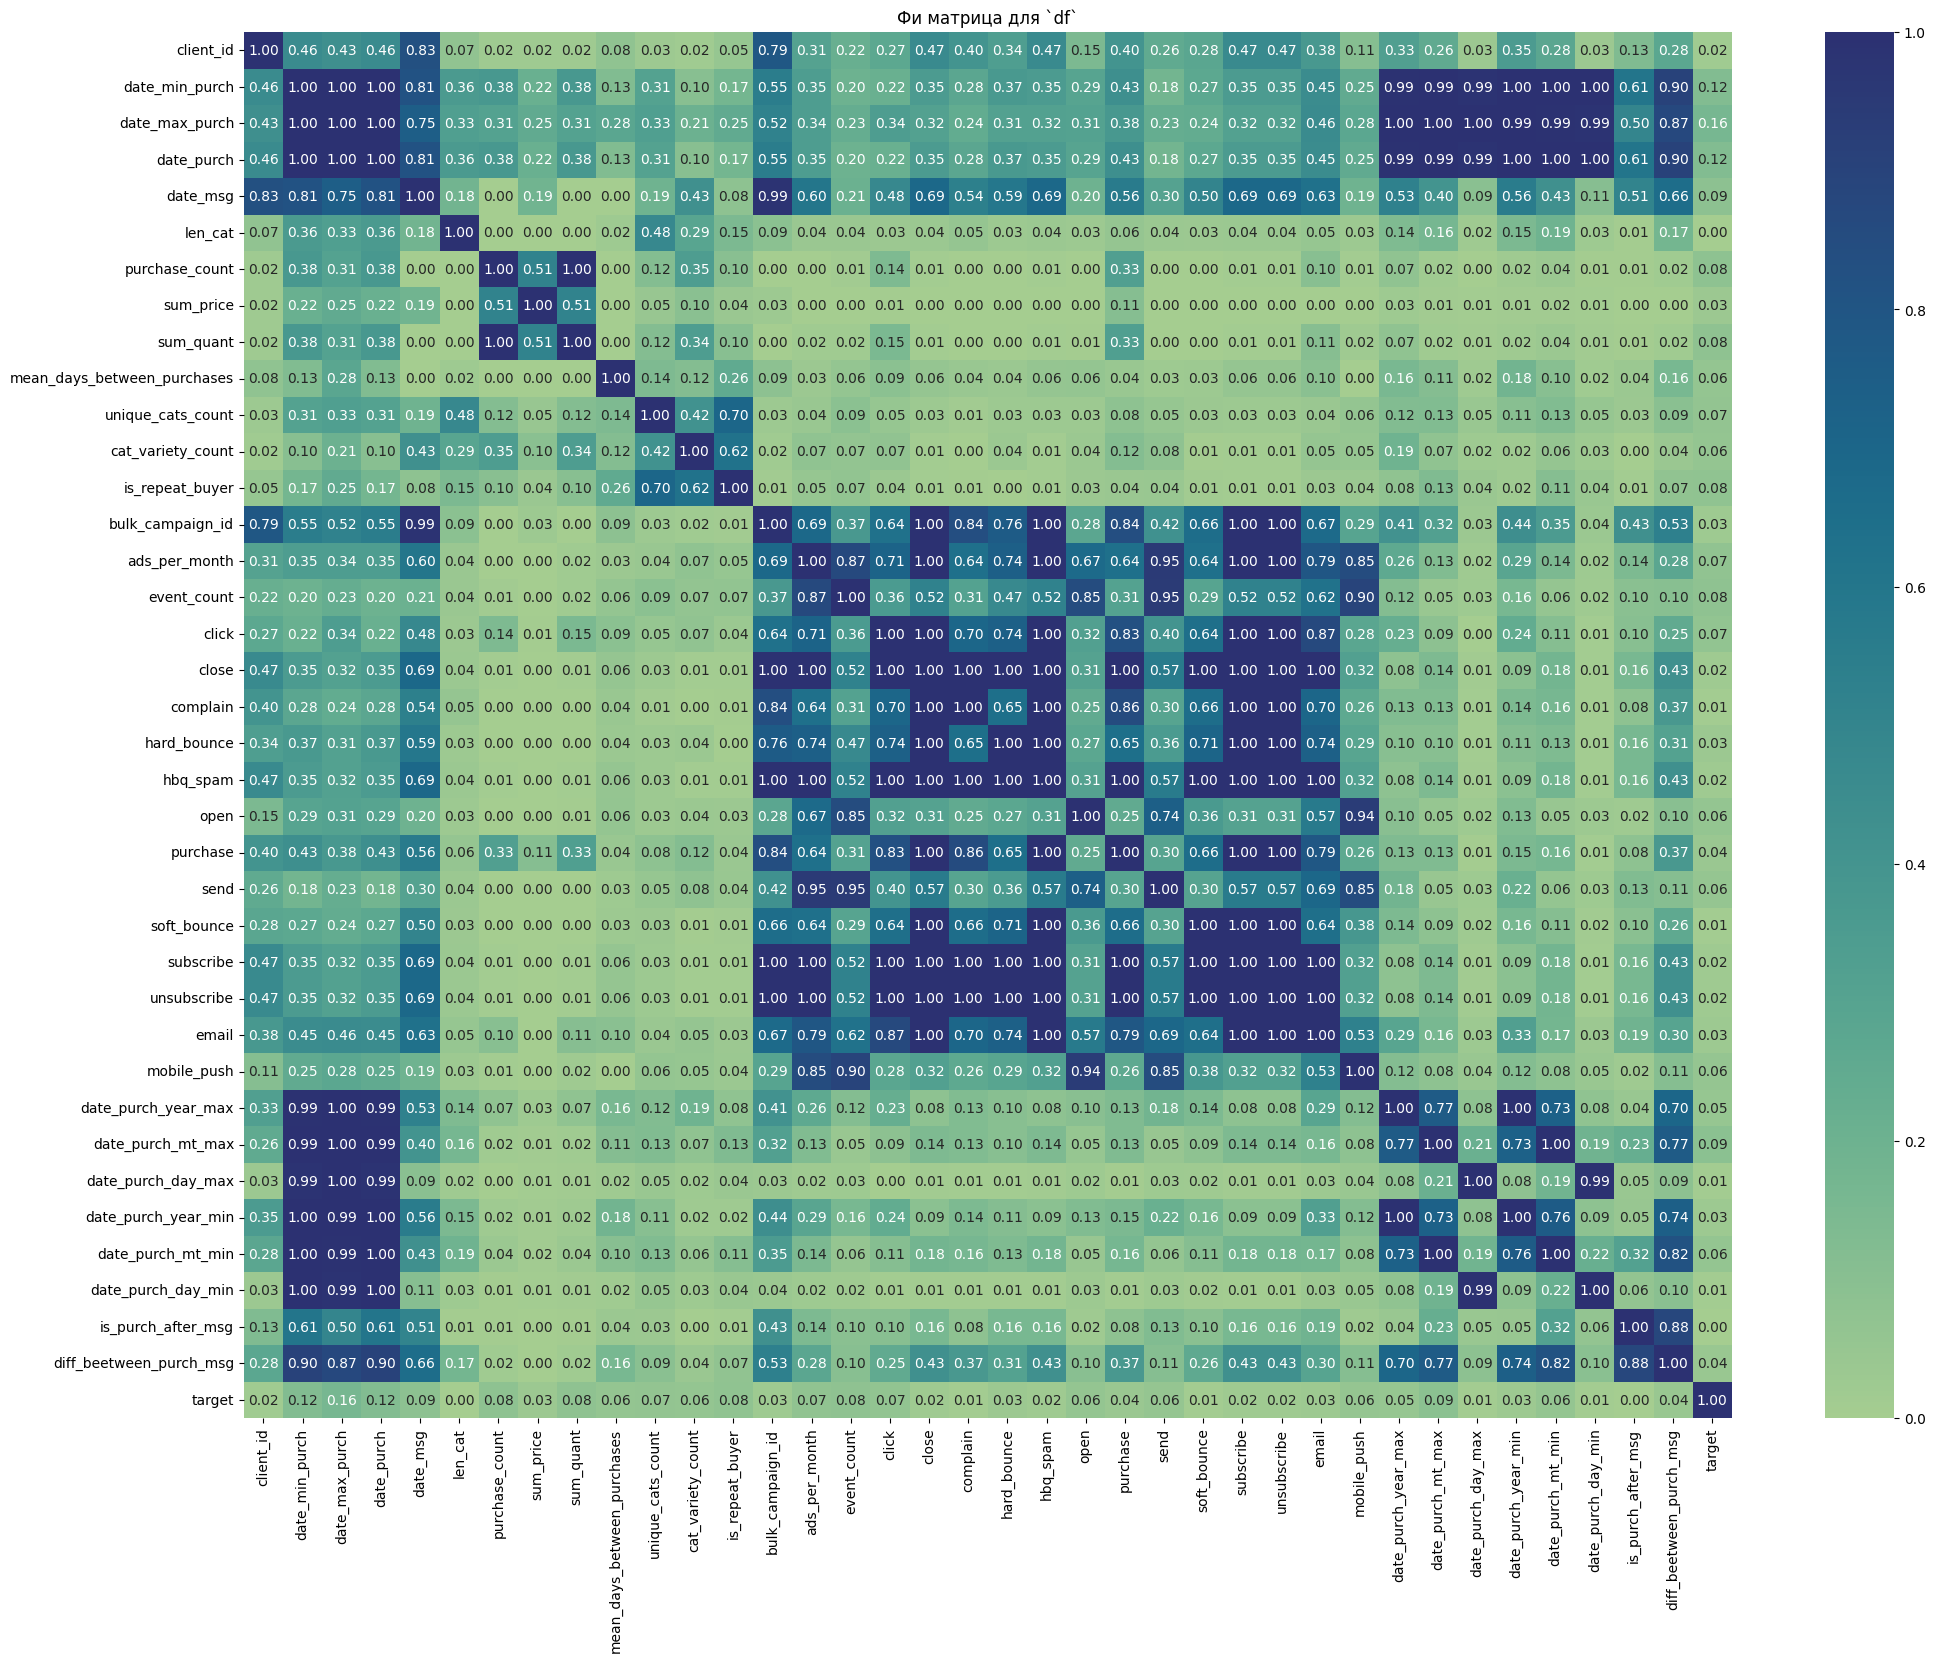

In [77]:
plot_phik(df[cols_based_full])

interval columns not set, guessing: ['lifetime_days', 'date_purch_year_max', 'date_purch_mt_max', 'date_purch_day_max', 'date_purch_year_min', 'date_purch_mt_min', 'date_purch_day_min', 'is_purch_after_msg', 'diff_beetween_purch_msg', 'date_purch_weekday', 'date_msg_weekday', 'target']


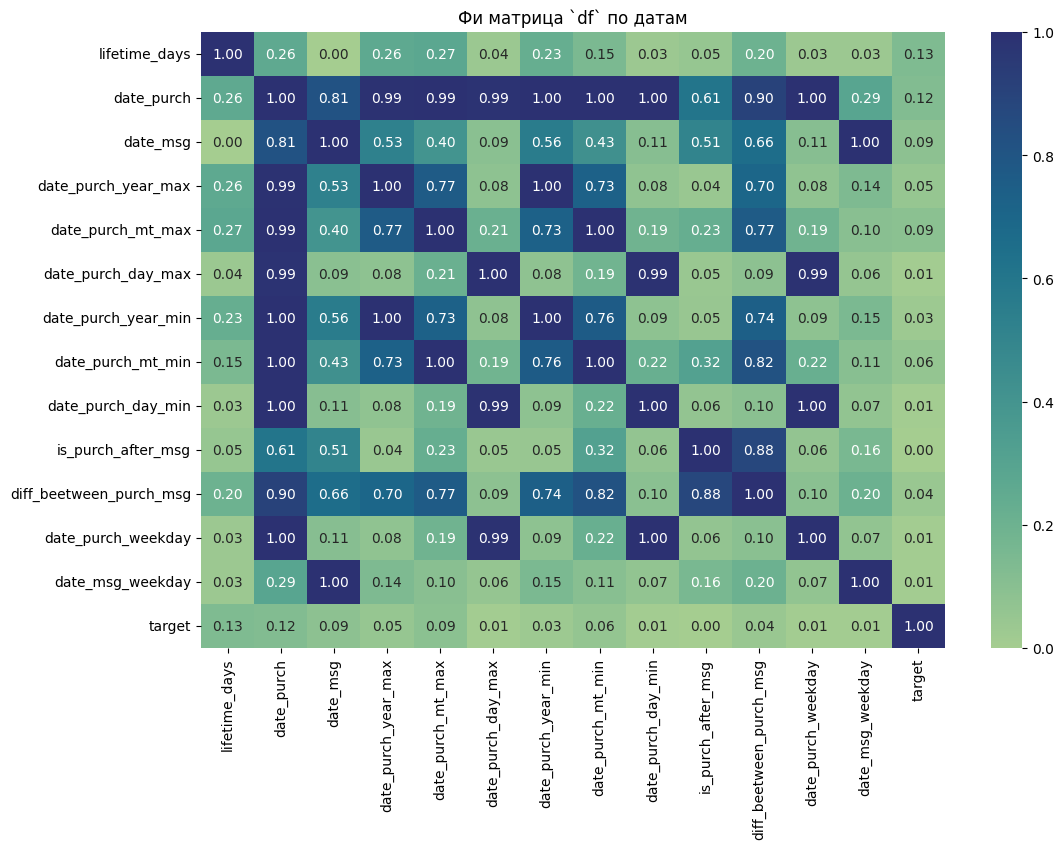

In [78]:
plot_phik(df[cols_date_based + target_col], 'Фи матрица `df` по датам', (12,8))

**__Корреляция по датам:__**

- `lifetime_days` - самая большая корреляция с таргетом 13%.
- `date_purch` и `date_msg` - имееют высокую корреляцию с остальными признаками, их можно убрать.
- `date_purch_day_max` и `date_purch_day_min` - высокая взаимная корреляция вероятно почти все одинаковы, можно обработать их взяв разницу меджу днями недели покупок клиентов, после чего логарифмируем.

In [79]:
len(df[df['date_purch_day_max'] == df['date_purch_day_min']])

43739

In [80]:
print(df.date_purch_day_max.value_counts() , df.date_purch_day_min.value_counts())

date_purch_day_max
4    13172
2     8282
5     7567
3     6417
1     5540
0     4560
6     4311
Name: count, dtype: int64 date_purch_day_min
4    13331
2     8508
5     7417
3     6442
1     5470
0     4479
6     4202
Name: count, dtype: int64


In [81]:
df['diff_max_min_day'] = np.log1p(np.abs(df.date_purch_day_max - df.date_purch_day_min))
df['lifetime_days'] = np.log1p(df['lifetime_days']) 

In [82]:
cols_date_based_clear = cols_date_based.copy()
cols_date_based_clear.remove('date_purch')
cols_date_based_clear.remove('date_msg')
cols_date_based_clear.remove('date_purch_day_max')
cols_date_based_clear.remove('date_purch_day_min')
cols_date_based_clear.append('diff_max_min_day')

interval columns not set, guessing: ['lifetime_days', 'date_purch_year_max', 'date_purch_mt_max', 'date_purch_year_min', 'date_purch_mt_min', 'is_purch_after_msg', 'diff_beetween_purch_msg', 'date_purch_weekday', 'date_msg_weekday', 'diff_max_min_day', 'target']


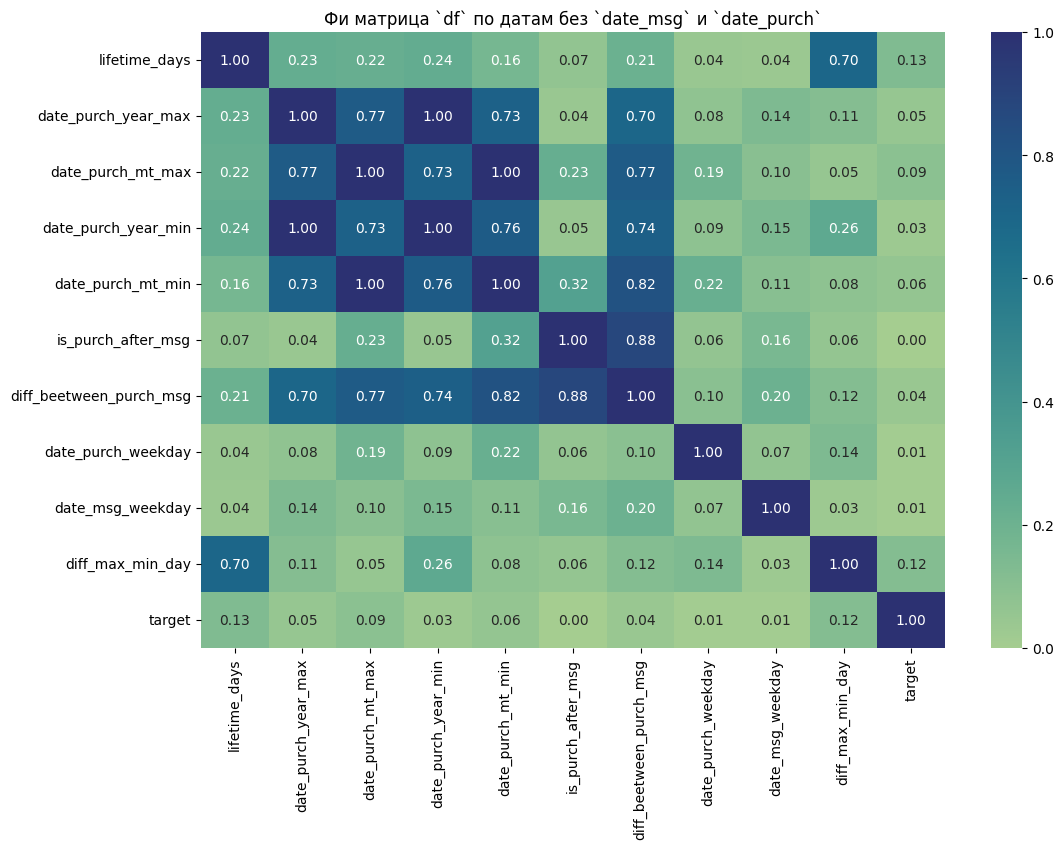

In [83]:
plot_phik(df[cols_date_based_clear + target_col], 'Фи матрица `df` по датам без `date_msg` и `date_purch`', (12,8))

Уберем оставшуюся сильную корреляцию между датами перед этапом создания pipeline

In [84]:
df_adv = df[df['subscribe'] != -99]
print(len(df_adv))

41982


interval columns not set, guessing: ['bulk_campaign_id', 'ads_per_month', 'event_count', 'click', 'close', 'complain', 'hard_bounce', 'hbq_spam', 'open', 'purchase', 'send', 'soft_bounce', 'subscribe', 'unsubscribe', 'email', 'mobile_push', 'target']


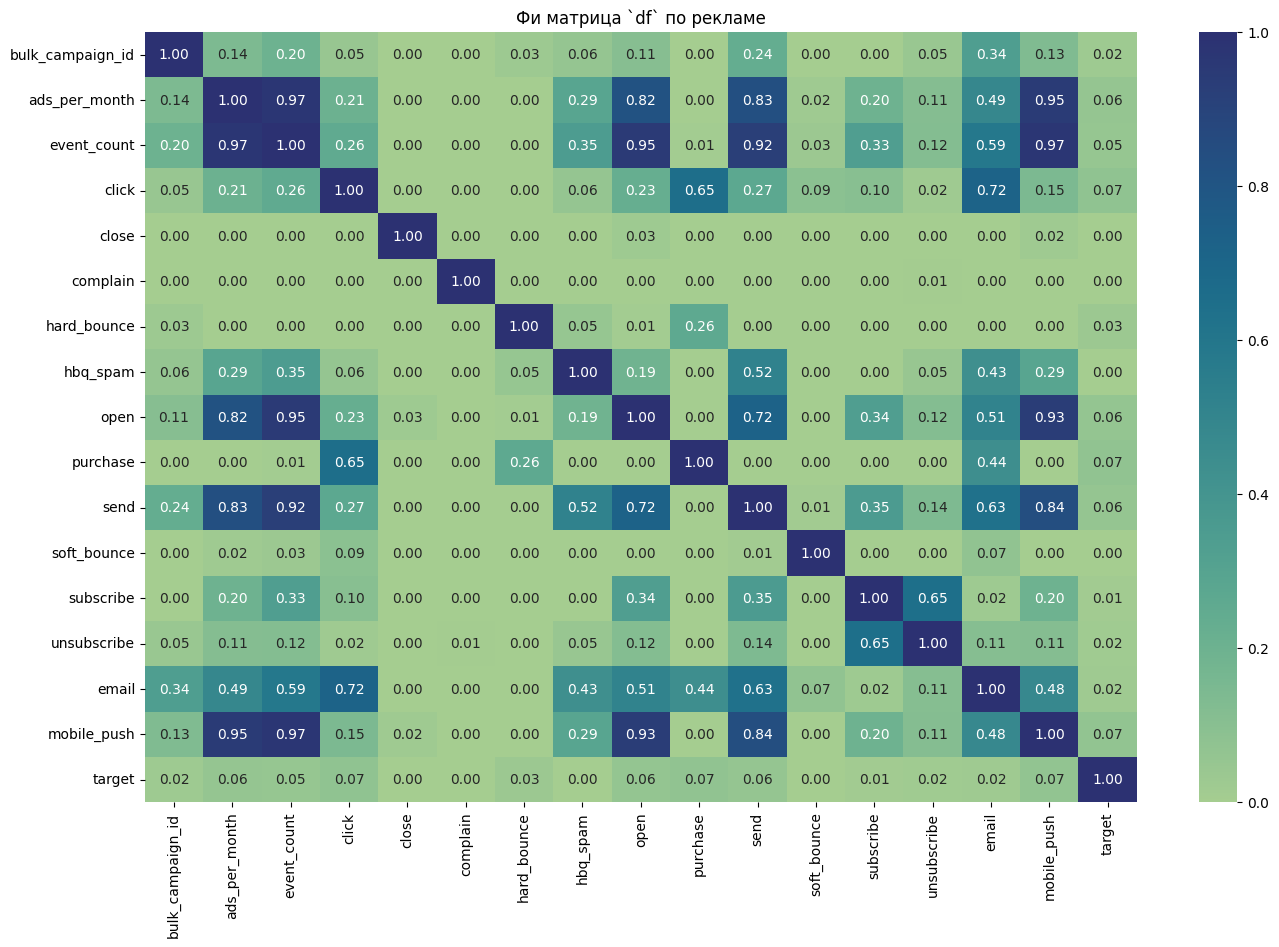

In [85]:
plot_phik(df_adv[cols_commerce_based + target_col], 'Фи матрица `df` по рекламе', (16,10))

**__Корреляция по рекламе:__**

-  `ads_per_month`, `event_count` - почти полная корреляция оставим `ads_per_month` больше корреляция с целевой.
-  `mobile_push` - высоская корреляиця с `open`, `send` что логично.

In [86]:
cols_commerce_based_clear = cols_commerce_based.copy() 
cols_commerce_based_clear.remove('event_count')

interval columns not set, guessing: ['len_cat', 'purchase_count', 'sum_price', 'sum_quant', 'mean_days_between_purchases', 'unique_cats_count', 'cat_variety_count', 'is_repeat_buyer', 'target']


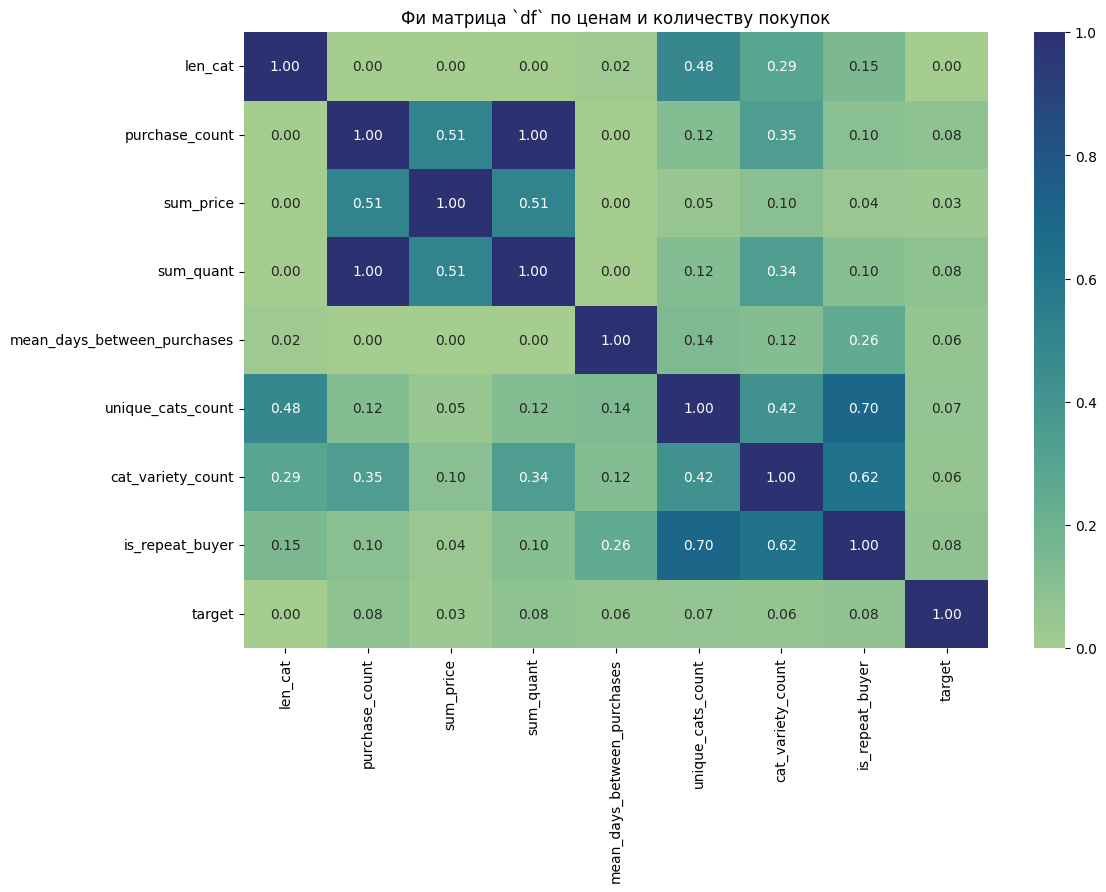

In [87]:
plot_phik(df[cols_numeric_based + target_col],  'Фи матрица `df` по ценам и количеству покупок', (12,8))

**__Корреляция по покупкам:__**

- можно убрать `len_cat` нулевая корреляция с целевой. 

In [88]:
cols_numeric_based_clear = cols_numeric_based.copy()
cols_numeric_based_clear.remove('len_cat')

In [89]:
feature_cols = cols_date_based_clear + cols_numeric_based_clear + cols_commerce_based_clear 

interval columns not set, guessing: ['lifetime_days', 'date_purch_year_max', 'date_purch_mt_max', 'date_purch_year_min', 'date_purch_mt_min', 'is_purch_after_msg', 'diff_beetween_purch_msg', 'date_purch_weekday', 'date_msg_weekday', 'diff_max_min_day', 'purchase_count', 'sum_price', 'sum_quant', 'mean_days_between_purchases', 'unique_cats_count', 'cat_variety_count', 'is_repeat_buyer', 'bulk_campaign_id', 'ads_per_month', 'click', 'close', 'complain', 'hard_bounce', 'hbq_spam', 'open', 'purchase', 'send', 'soft_bounce', 'subscribe', 'unsubscribe', 'email', 'mobile_push', 'target']


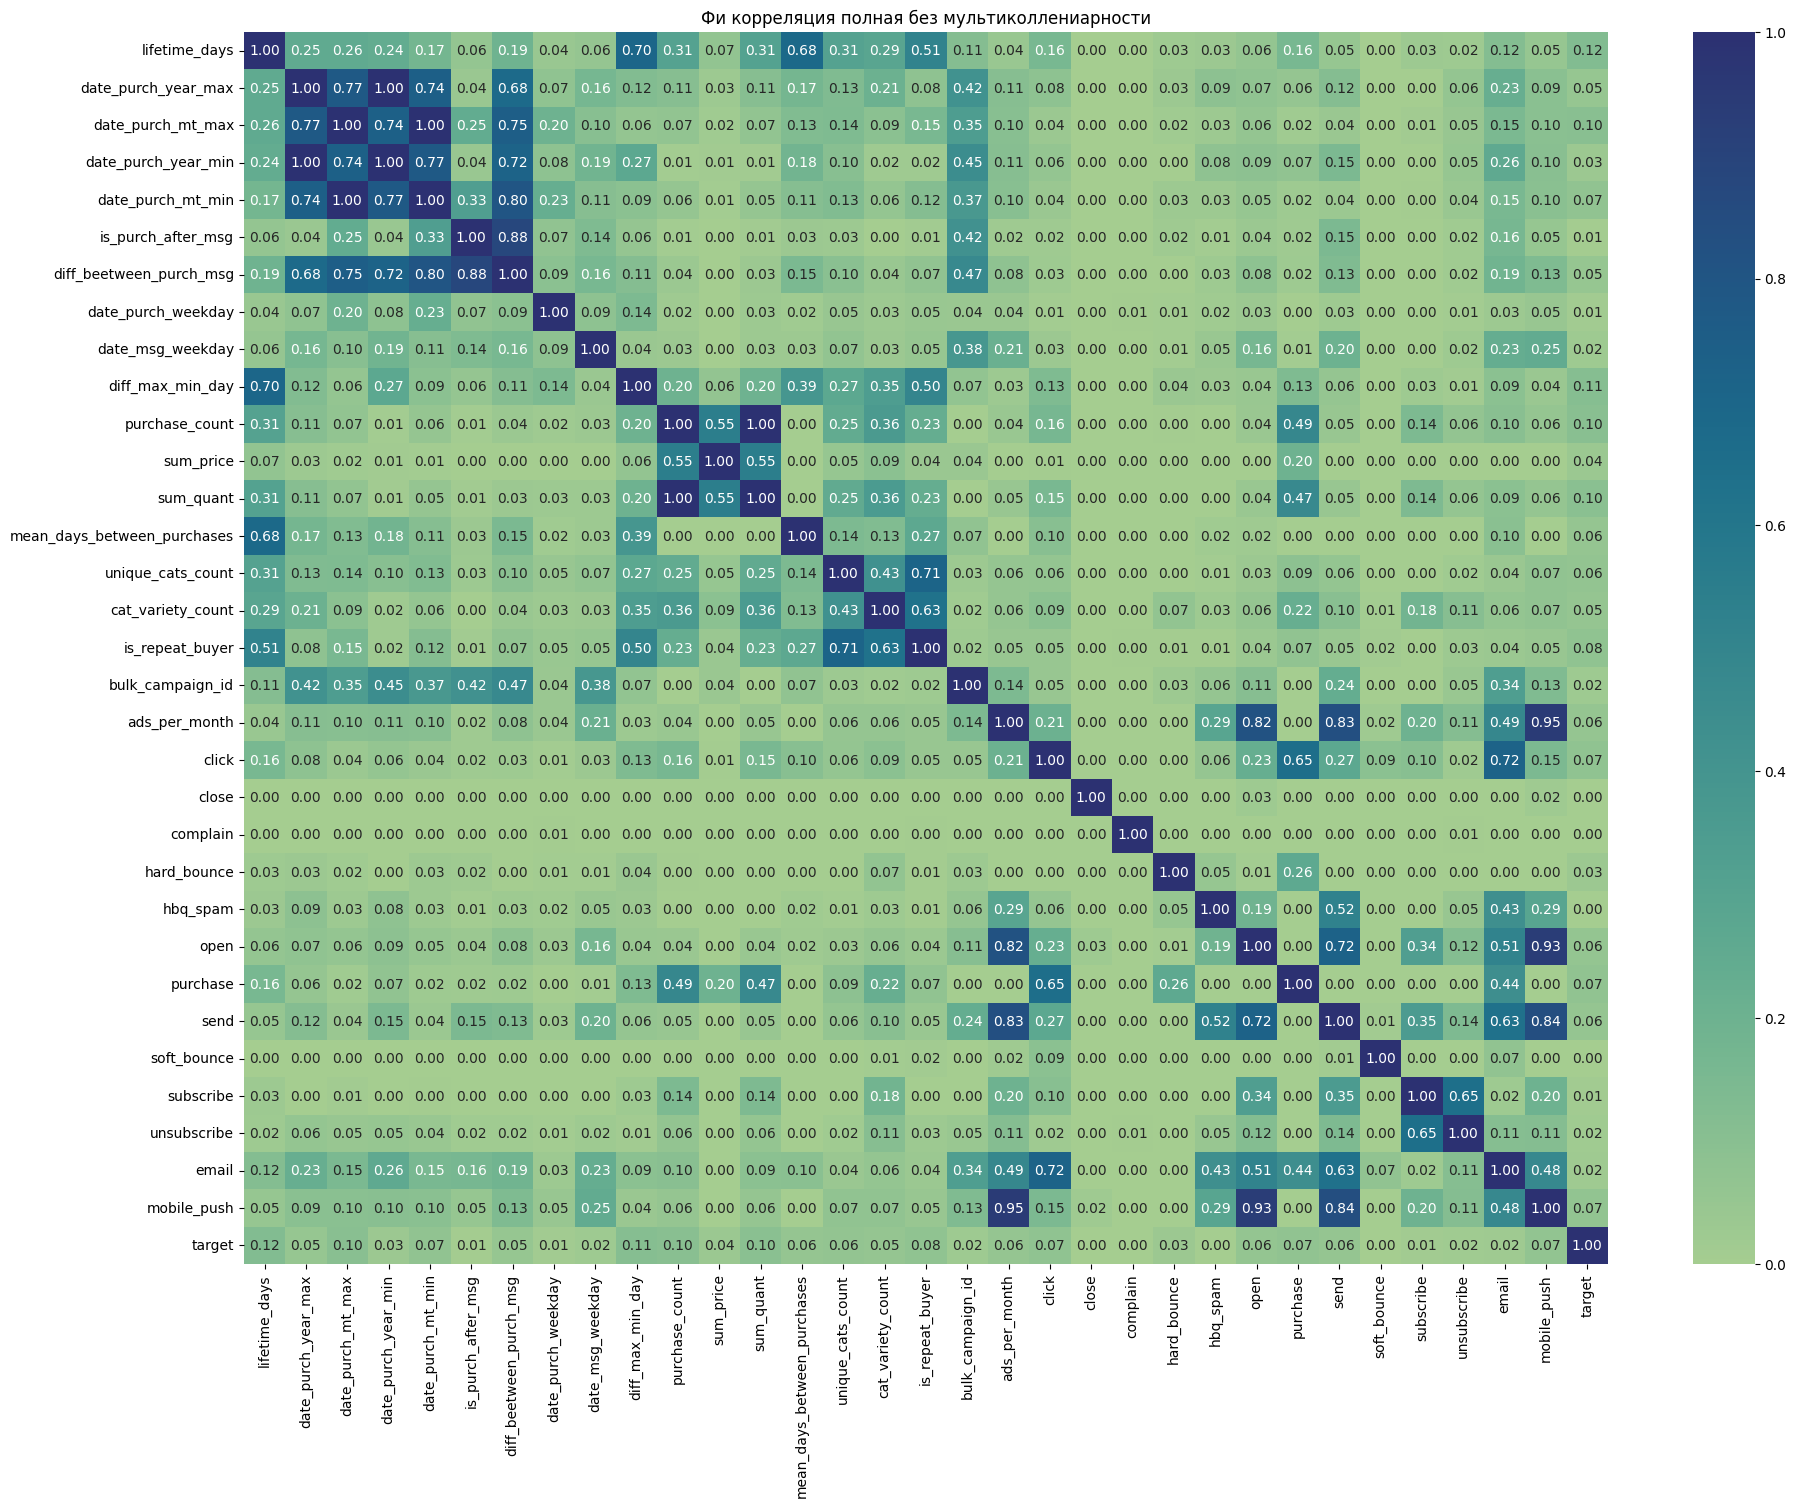

In [90]:
plot_phik(df_adv[feature_cols + target_col], 'Фи корреляция полная без мультиколлениарности', figsize=(22,16))

## 2.2 Анализ  признаков рекламы

In [91]:
def create_report(df, features, report_name='report_top_features'):
    report = ProfileReport(
        df[features + ['target']], 
        interactions={"targets": ['target']},
        progress_bar=False  
    )
    return report 

Рассмотрим рекламу в двух датафреймах относительно таргета где была реклама и где её не было 

In [92]:
df_adv = df[df['email'] != -99].copy() 
df_not_adv = df[df['email'] == -99].copy()
print(df_adv.shape, df_not_adv.shape)

(41982, 44) (7867, 44)


Рассмотрим `df_adv`

### 2.2.1 Вначале саму рекламную компанию `bulk_campaign_id`

In [93]:
df_adv.bulk_campaign_id.nunique()

1054

In [94]:
val_counts_bulk = df_adv.bulk_campaign_id.value_counts()
idx_most_common_bulk = val_counts_bulk[val_counts_bulk > 100].index.tolist() 

In [95]:
group_most_common_bulk = df_adv.query('bulk_campaign_id in @idx_most_common_bulk').groupby('bulk_campaign_id')['target'].agg(['sum', 'count']).reset_index()
group_most_common_bulk.columns = ['bulk_campaign_id', 'target_buys', 'count_target']

In [96]:
group_most_common_bulk['conversion_target'] = group_most_common_bulk['target_buys'] /  group_most_common_bulk['count_target']
group_most_common_bulk['conversion_target'] = np.round(group_most_common_bulk['conversion_target'] * 100, 3)
group_most_common_bulk.sort_values('conversion_target', ascending=False)

bulk_campaign_id  target_buys  count_target  conversion_target
11            5029.0            4           125              3.200
3             4498.0           87          2782              3.127
0             4439.0           15           504              2.976
1             4463.0          183          7269              2.518
7             4617.0           11           524              2.099
12            5075.0            6           301              1.993
6             4568.0          109          5703              1.911
14            6697.0            2           116              1.724
5             4517.0            2           124              1.613
4             4516.0           24          1494              1.606
10            4965.0            5           347              1.441
2             4492.0          142         10074              1.410
17           12760.0            2           162              1.235
15            7879.0            5           421              1.188
9             4679.0            8           794              1.008
16            8615.0            1           104              0.962
8             4664.0           10          1122              0.891
13            5662.0            2           319              0.627

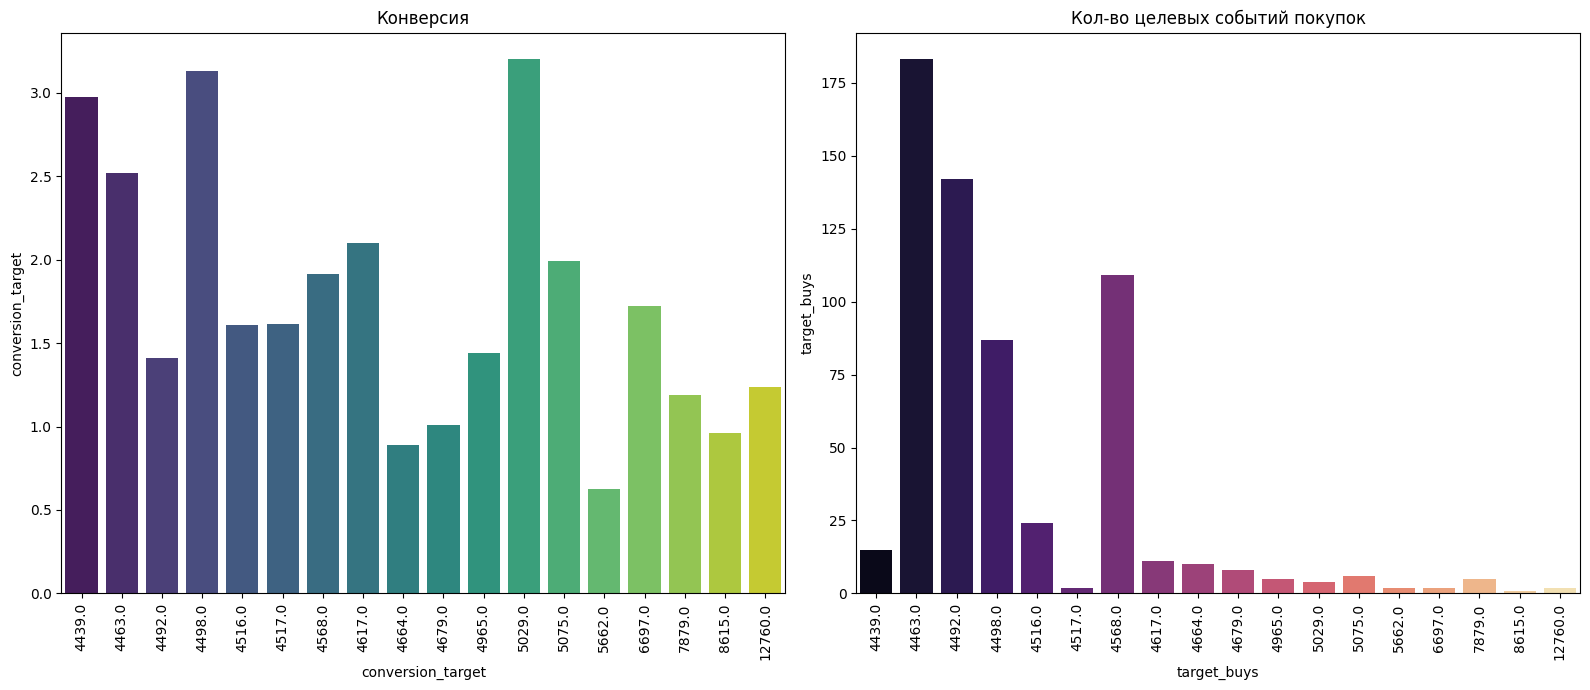

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

sns.barplot(
    data=group_most_common_bulk,
    y='conversion_target',
    x='bulk_campaign_id',
    ax=axes[0],
    palette='viridis'
)
axes[0].set_title('Конверсия')
axes[0].set_xlabel('conversion_target')
axes[0].set_xticklabels(labels=axes[0].get_xticklabels(), rotation = 90)
sns.barplot(
    data=group_most_common_bulk,
    y='target_buys',
    x='bulk_campaign_id',
    ax=axes[1],
    palette='magma'
)
axes[1].set_title('Кол-во целевых событий покупок')
axes[1].set_xlabel('target_buys')
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

In [98]:
df_not_adv.groupby('bulk_campaign_id')['target'].agg('sum', 'count')

bulk_campaign_id
-99.0    115
Name: target, dtype: int64

In [99]:
115 / len(df_not_adv)

0.014618024659972036

In [100]:
group_most_common_bulk['target_buys'].sum() / group_most_common_bulk['count_target'].sum()

0.019142016416292394

In [101]:
interest_conversion_bulk = [4463.0, 4498.0] 

In [102]:
group_most_common_bulk.query('bulk_campaign_id in @interest_conversion_bulk')['target_buys'].sum() /\
group_most_common_bulk.query('bulk_campaign_id in @interest_conversion_bulk')['count_target'].sum()

0.026862998706596357

Вывод по `bulk_campaign_id`:
- Само проведение рекламной компании вляет на пользователя.
- Наиболее успешные рекламные компании: [4463.0, 4498.0] с точки зрения количества пользователей и покупок, можно сделать отдельный бинарный признак для того чтобы охарактеризовать эти компании.  

In [103]:
df['is_popular_bulk'] = (df.bulk_campaign_id.isin(interest_conversion_bulk)).astype(int)
df['is_popular_bulk'].value_counts()

is_popular_bulk
0    39798
1    10051
Name: count, dtype: int64

In [104]:
df_adv['is_popular_bulk'] = (df_adv.bulk_campaign_id.isin(interest_conversion_bulk)).astype(int)

### 2.2.2 Рассмотрение `ads_per_month` среднее количество рекламы в месяц

In [105]:
def plot_kde(df_plot, col_look, title='Распределение рекламы по классам target'):
    plt.figure(figsize=(8, 5))
    sns.kdeplot(df_plot[df_plot['target'] == 0][col_look], label='Target=0', fill=True)
    sns.kdeplot(df_plot[df_plot['target'] == 1][col_look], label='Target=1', fill=True)
    plt.xlabel(col_look)
    plt.ylabel('Распределение')
    plt.title(title)
    plt.legend()
    plt.show()

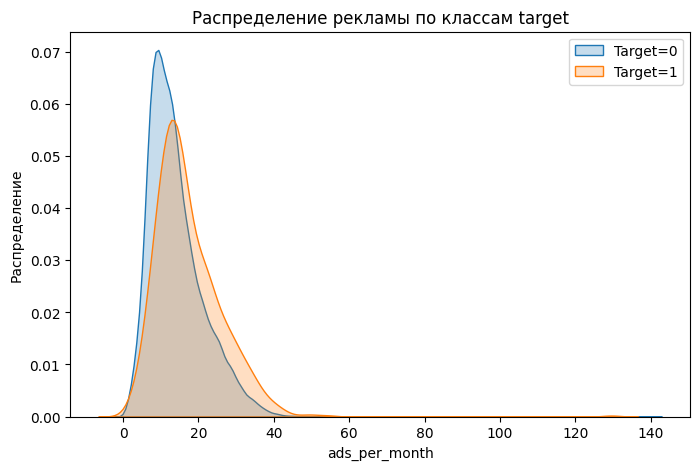

In [106]:
plot_kde(df_adv, 'ads_per_month')

Вывод по `ads_per_month`:

- В среднем количество рекламы у пользователей которые покупают больше. 

### 2.2.3 Анализ `click` 

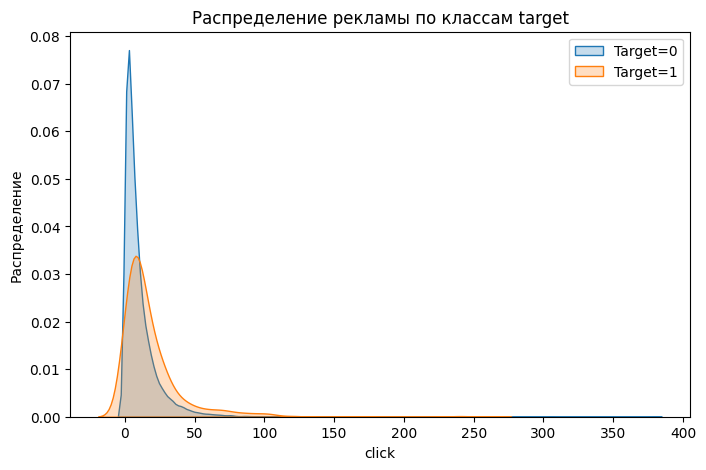

In [107]:
plot_kde(df_adv, 'click')

Вывод по `click`: 

- В среднем пользователи чаще кликают при покупке.  

### 2.2.4 Рассмотрение `complain` - Жалоб 

In [108]:
df_adv.complain.value_counts()

complain
0.0     41724
1.0       213
2.0        28
7.0         3
4.0         3
3.0         3
5.0         2
6.0         2
47.0        1
80.0        1
27.0        1
8.0         1
Name: count, dtype: int64

In [109]:
group_complain = df_adv.groupby('complain')['target'].agg(['sum', 'count']).reset_index()
group_complain

complain  sum  count
0        0.0  840  41724
1        1.0    5    213
2        2.0    1     28
3        3.0    0      3
4        4.0    0      3
5        5.0    0      2
6        6.0    0      2
7        7.0    0      3
8        8.0    0      1
9       27.0    0      1
10      47.0    0      1
11      80.0    0      1

Вывод по `complain`: 

- В основном люди не жалуются, можно смело сказать что признак не информативен и убрать его их анализа, т.к. он почти целиком состоит из `0`; 

In [110]:
df.drop(columns=['complain'], axis=1, inplace=True)
feature_cols.remove('complain')

### 2.2.5 Анализ `hard_bounce` - ошибки при доставке письма 

In [111]:
df_adv.groupby('hard_bounce')['target'].agg(['sum', 'count']).reset_index()

hard_bounce  sum  count
0           0.0  642  31348
1           1.0  143   7600
2           2.0   29   1866
3           3.0   16    624
4           4.0    5    224
5           5.0    5    131
6           6.0    2     52
7           7.0    1     46
8           8.0    0     26
9           9.0    1     25
10         10.0    0     12
11         11.0    0      7
12         12.0    0      4
13         13.0    1      5
14         14.0    0      2
15         15.0    0      2
16         16.0    0      2
17         17.0    0      1
18         18.0    0      1
19         19.0    0      1
20         23.0    0      1
21         31.0    0      1
22         36.0    1      1

In [112]:
group_hard_bounce = df_adv.groupby('hard_bounce')['target'].agg(['sum', 'count']).reset_index()

group_hard_bounce['hb_group'] = np.where(
    group_hard_bounce['hard_bounce'] == 0, 0,
    np.where(group_hard_bounce['hard_bounce'] == 1, 1, 2)
)

group_hard_bounce = group_hard_bounce.groupby('hb_group')[['sum', 'count']].sum().reset_index()
group_hard_bounce['converse'] = group_hard_bounce['sum'] / group_hard_bounce['count']
group_hard_bounce

hb_group  sum  count  converse
0         0  642  31348  0.020480
1         1  143   7600  0.018816
2         2   61   3034  0.020105

Вывод по `hard_bouce`: 

- Можно выделить три основные группы `0`, `1`, и больше `1`, конверсия около 2-х процентов, признак не сильно информативен, можно удалить. 

In [113]:
df.drop(columns=['hard_bounce'], axis=1, inplace=True)
df_adv.drop(columns=['hard_bounce'], axis=1, inplace=True)
feature_cols.remove('hard_bounce')

### 2.2.6 Анализ `hbq_spam` количестово спама 

In [114]:
df_adv.groupby('hbq_spam')['target'].agg(['sum', 'count']).reset_index()

hbq_spam  sum  count
0       0.0  835  41238
1       1.0   11    728
2       2.0    0     16

Вывод по `hbq_spam`: 

- Иммется три группы также малоинфоративный признак, основная масса около `0`.  

In [115]:
df.drop(columns=['hbq_spam'], axis=1, inplace=True)
df_adv.drop(columns=['hbq_spam'], axis=1, inplace=True)
feature_cols.remove('hbq_spam')

### 2.2.7 Анализ `open` письмо ли собщение было открыто 

In [116]:
df_adv.groupby('open')['target'].agg(['sum', 'count']).reset_index()[:10]

open  sum  count
0   0.0  116   7235
1   1.0    9    915
2   2.0    8    950
3   3.0   10    904
4   4.0    9    835
5   5.0   10    791
6   6.0    8    700
7   7.0   13    665
8   8.0    7    668
9   9.0    7    590

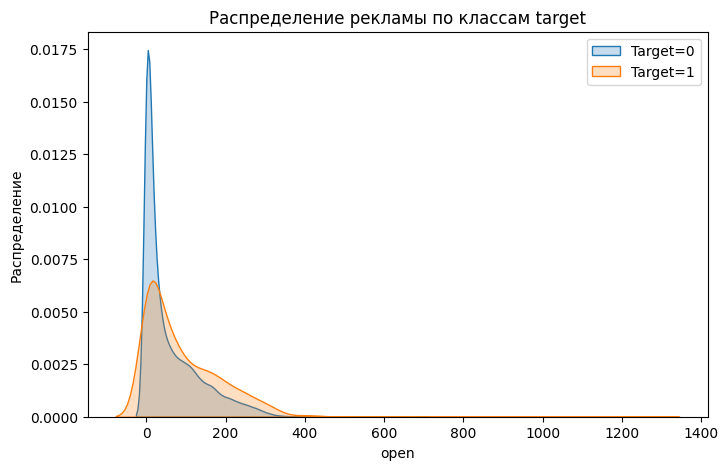

In [117]:
plot_kde(df_adv, 'open')

In [118]:
bins = [-1, 0, 10, 50, 100, 10000]
labels = ['0', '1-10', '11-50', '51-100', '101+']
df_adv['open_bin'] = pd.cut(df_adv['open'], bins=bins, labels=labels)
open_target = df_adv.groupby('open_bin')['target'].agg(['mean', 'count']).reset_index()
open_target.columns = ['open_bin', 'conversion_rate', 'count']
print(open_target)

  open_bin  conversion_rate  count
0        0         0.016033   7235
1     1-10         0.011376   7560
2    11-50         0.017555  11165
3   51-100         0.024009   6206
4     101+         0.030460   9816


Вывод по `open`: 

- Среднее и тех кто покупает и кто не покупает почти совпадает, однако покупатели которые покупают чаще открывают рекламу.
- Можно также создать бинарный признак того что пользователь часто просматривает рекламу, выше 100 просмотров конверсия составляет около 3 %.

In [119]:
df_adv['is_most_open'] = (df_adv.open >=100).astype(int)
df['is_most_open'] = (df.open >=100).astype(int)

### 2.2.8 Анализ по `purchase`

In [120]:
df_adv.purchase.value_counts()

purchase
1.0     27594
2.0      6087
0.0      4497
3.0      2004
4.0       820
5.0       450
6.0       225
7.0       103
8.0        59
9.0        47
10.0       22
11.0       19
14.0       10
16.0        9
13.0        9
12.0        7
15.0        4
17.0        4
19.0        2
25.0        2
23.0        2
22.0        1
81.0        1
20.0        1
36.0        1
18.0        1
75.0        1
Name: count, dtype: int64

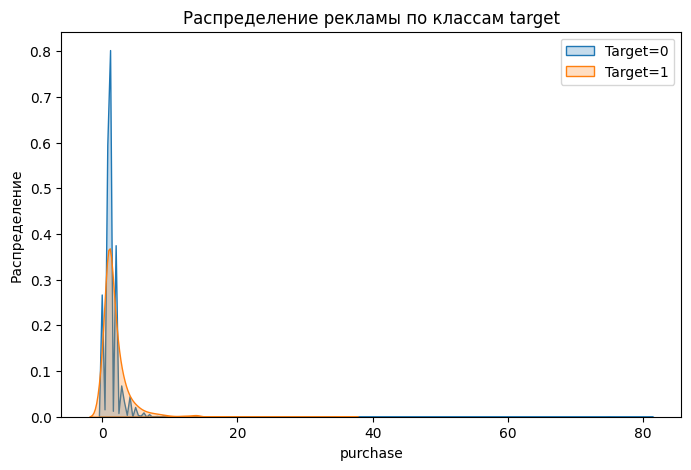

In [121]:
plot_kde(df_adv, 'purchase')

In [122]:
bins = [-0.1, 0.9, 1.9, 3.9, 6.9, 10.9, float('inf')]
labels = ['0', '1', '2-3', '4-6', '7-10', '10+']
df_adv['purchase_bin'] = pd.cut(df_adv['purchase'], bins=bins, labels=labels)
purchase_target = df_adv.groupby('purchase_bin')['target'].agg(['mean', 'count']).reset_index()
purchase_target.columns = ['purchase_bin', 'conversion_rate', 'count']
print(purchase_target)

  purchase_bin  conversion_rate  count
0            0         0.020236   4497
1            1         0.015076  27594
2          2-3         0.029168   8091
3          4-6         0.047492   1495
4         7-10         0.086580    231
5          10+         0.162162     74


In [123]:
df['purchase_bin'] = pd.cut(df['purchase'], bins=bins, labels=labels)

Вывод по `purchase`: 

- Основаная доля покупок - `1` можно заметить что конверсия растет с количетсвом покупок.
- И категория больше 10+ покупок выделяется 

### 2.2.9 Анализ `send`

In [124]:
df_adv.send.value_counts()

send
148.0    212
134.0    205
131.0    204
137.0    203
143.0    203
        ... 
519.0      1
492.0      1
516.0      1
532.0      1
582.0      1
Name: count, Length: 537, dtype: int64

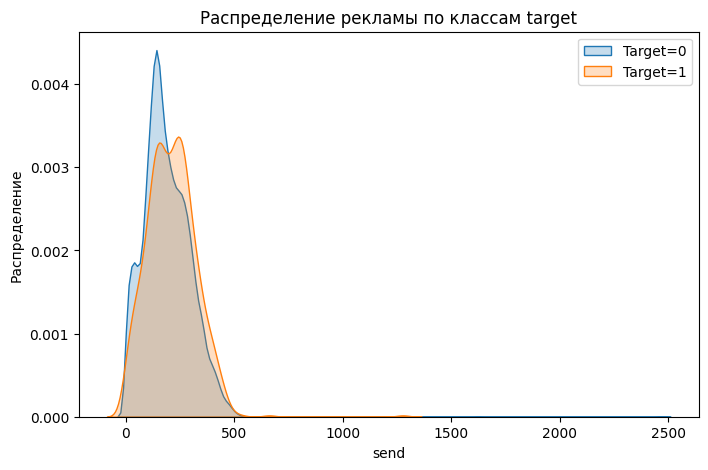

In [125]:
plot_kde(df_adv, 'send')

In [126]:
bins = [x for x in range(0, 550, 50)] + [float('inf')]
labels = [str(x) for x in range(0, 550, 50)]#['0-10', '10-50', '50-100', '100-200', '200-500', '500+']
df_adv['send_bin'] = pd.cut(df_adv['send'], bins=bins, labels=labels)
send_target = df_adv.groupby('send_bin')['target'].agg(['mean', 'count']).reset_index()
send_target.columns = ['send_bin', 'conversion_rate', 'count']
print(send_target)

   send_bin  conversion_rate  count
0         0         0.014691   3948
1        50         0.016722   4485
2       100         0.016017   8491
3       150         0.017869   7555
4       200         0.023725   5901
5       250         0.026350   5313
6       300         0.024100   3278
7       350         0.027350   1755
8       400         0.030134    896
9       450         0.016393    305
10      500         0.055556     54


Вывод по `send`: 

- Высокая конверсия на отправках рекламы более 500 около 5% но это также может быть обусловленно небольшим количеством.
- Интереснее диапазон около 350 - 400 - 450 до 3%.

In [127]:
df['send_bin'] = pd.cut(df['send'], bins=bins, labels=labels)

### 2.2.10  Анализ `soft_bounce` когда реклама возвращалась 

In [128]:
df_adv.soft_bounce.value_counts().head()

soft_bounce
0.0    40400
1.0     1155
2.0       78
4.0       31
5.0       29
Name: count, dtype: int64

In [129]:
bins = [-0.1, 0.9, 1.9, float('inf')]
labels = ['0', '1', '2+']
df_adv['soft_bounce_cat'] = pd.cut(
    df_adv['soft_bounce'],
    bins=bins,
    labels=labels
)

# Группируем по категориям и считаем конверсию
group_soft = df_adv.groupby('soft_bounce_cat')['target'].agg(['sum', 'count', 'mean']).reset_index()
group_soft.columns = ['soft_bounce', 'conversions', 'total', 'conversion_rate']
print(group_soft)

  soft_bounce  conversions  total  conversion_rate
0           0          807  40400         0.019975
1           1           32   1155         0.027706
2          2+            7    427         0.016393


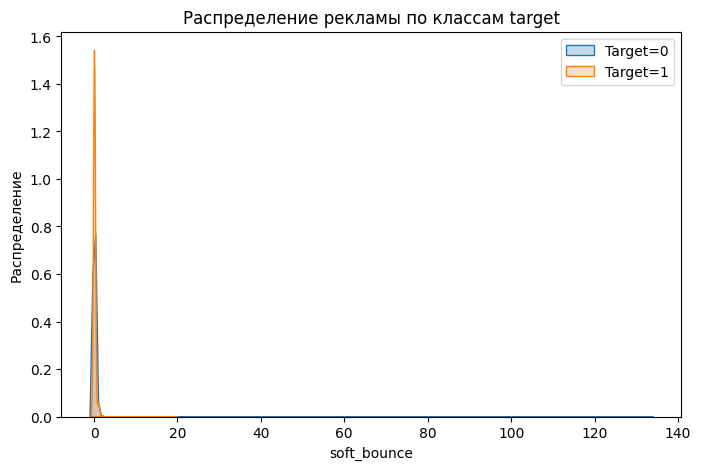

In [130]:
plot_kde(df_adv, 'soft_bounce')

Вывод по `soft_bounce`: 

- Выделяется категория `1` почти 3% конверсии
- Вероятно впоследсвии будет иметь около нулевую корреляцию с целевой, можно будет удалить.

In [131]:
df['soft_bounce_cat'] = pd.cut(
    df['soft_bounce'],
    bins=bins,
    labels=labels
)

### 2.2.11 Анализ `subscribe`, `unsubscribe`

In [132]:
df_adv.subscribe.value_counts()

subscribe
0.0    41914
1.0       61
2.0        6
3.0        1
Name: count, dtype: int64

In [133]:
df_adv.groupby('subscribe')['target'].agg(['sum', 'count'])

sum  count
subscribe            
0.0        844  41914
1.0          1     61
2.0          1      6
3.0          0      1

In [134]:
df_adv.groupby('unsubscribe')['target'].agg(['sum', 'count'])

sum  count
unsubscribe            
0.0          833  39953
1.0            9   1592
2.0            3    345
3.0            1     63
4.0            0     16
5.0            0      6
6.0            0      3
7.0            0      1
8.0            0      3

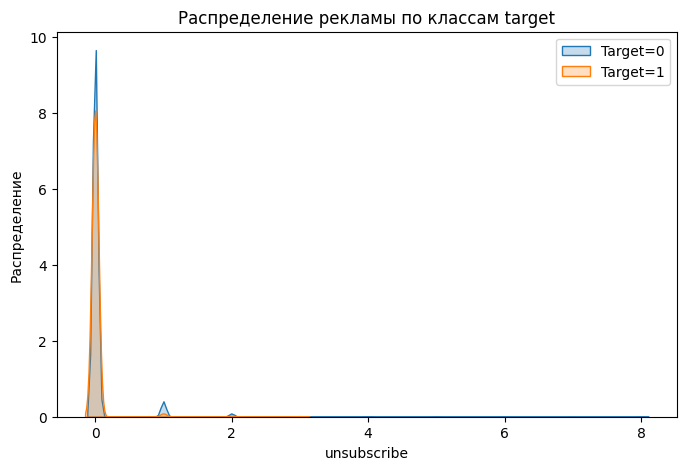

In [135]:
plot_kde(df_adv, 'unsubscribe')

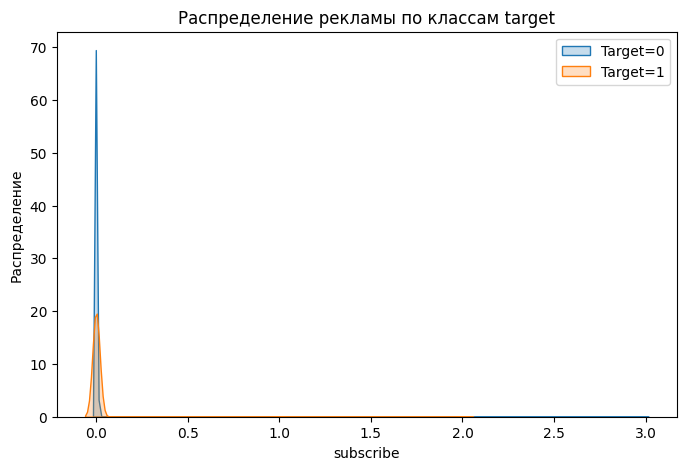

In [136]:
plot_kde(df_adv, 'subscribe')

Вывод по `subscribe`, `unsubscribe`: 

- Признаки являются малоинформативными.

In [137]:
df.drop(columns=['subscribe', 'unsubscribe'], axis=1, inplace=True)
feature_cols.remove('subscribe')
feature_cols.remove('unsubscribe')

### 2.2.12 Анализ `email`, `mobile_push`

In [138]:
print(df_adv.email.value_counts(), df_adv.mobile_push.value_counts())

email
0.0      10087
181.0      217
166.0      215
178.0      204
169.0      199
         ...  
488.0        1
390.0        1
419.0        1
805.0        1
645.0        1
Name: count, Length: 488, dtype: int64 mobile_push
0.0       11623
2.0         339
4.0         233
6.0         209
8.0         201
          ...  
738.0         1
638.0         1
652.0         1
653.0         1
2294.0        1
Name: count, Length: 665, dtype: int64


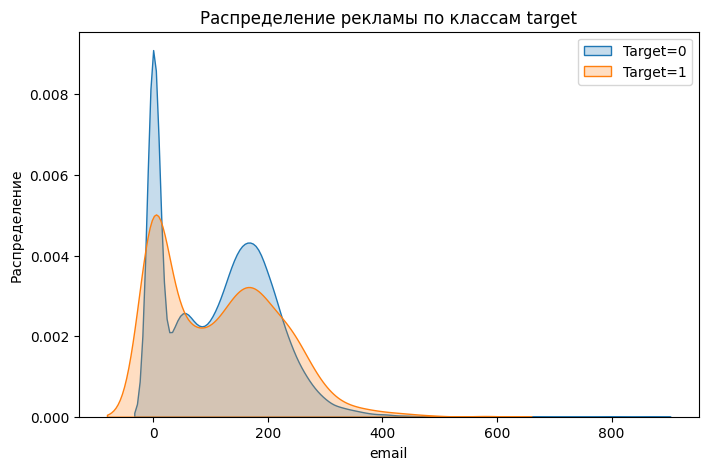

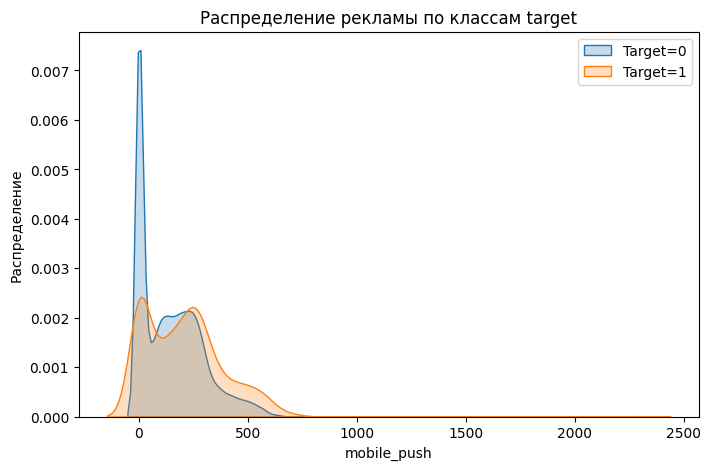

(None, None)

In [139]:
plot_kde(df_adv, 'email'), plot_kde(df_adv, 'mobile_push')

In [140]:
df_adv['email_bin'] = pd.cut(
    df_adv['email'],
    bins=[-1, 0, 50, 100, 150, 200, 250, 300, np.inf],
    labels=['0',  '1-50', '51-100','101-150', '151-200', '201-250', '251-300', '300+']
)

email_result = df_adv.groupby('email_bin')['target'].agg(['sum', 'count', 'mean'])
email_result

sum  count      mean
email_bin                      
0          246  10087  0.024388
1-50        67   3479  0.019258
51-100      87   4976  0.017484
101-150    114   6852  0.016637
151-200    145   8789  0.016498
201-250    103   5126  0.020094
251-300     54   1802  0.029967
300+        30    871  0.034443

In [141]:
df_adv['mobile_push_bin'] = pd.cut(
    df_adv['mobile_push'],
    bins=[-100, 1, 50, 100, 200,250,300, 350, 400, 450, 500, 550, np.inf],
    labels=['0-1', '1-50','51-100', '51-200', '201-250', '251-300', '301-350','351-400', '401-450', '451-500', '501-550', '550+'],
    right=False
)
mobile_result = df_adv.groupby('mobile_push_bin')['target'].agg(['sum', 'count', 'mean']).reset_index()
mobile_result

mobile_push_bin  sum  count      mean
0              0-1  171  11623  0.014712
1             1-50   63   4123  0.015280
2           51-100   43   3423  0.012562
3           51-200  148   8554  0.017302
4          201-250  100   4534  0.022056
5          251-300  102   3877  0.026309
6          301-350   62   1985  0.031234
7          351-400   33   1181  0.027942
8          401-450   28    922  0.030369
9          451-500   33    726  0.045455
10         501-550   26    590  0.044068
11            550+   37    444  0.083333

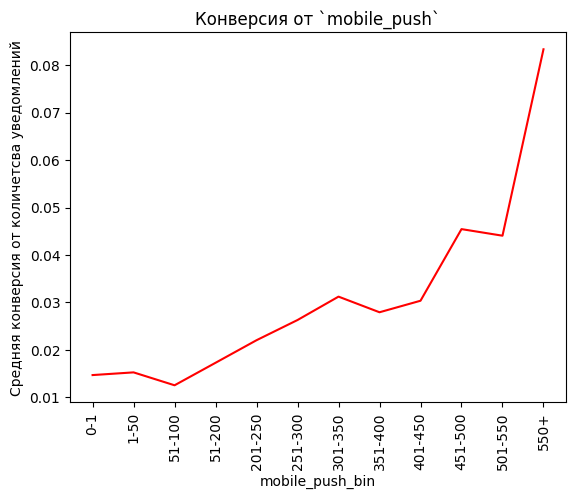

In [142]:
sns.lineplot(data=mobile_result, x="mobile_push_bin", y="mean", color='red')
plt.xticks(rotation=90)
plt.title('Конверсия от `mobile_push`')
plt.ylabel('Средняя конверсия от количетсва уведомлений')
plt.show()

In [143]:
# Для email
print(df_adv.groupby('email_bin')['target'].mean().sort_values(ascending=False))

# Для mobile_push
print(df_adv.groupby('mobile_push_bin')['target'].mean().sort_values(ascending=False))

email_bin
300+       0.034443
251-300    0.029967
0          0.024388
201-250    0.020094
1-50       0.019258
51-100     0.017484
101-150    0.016637
151-200    0.016498
Name: target, dtype: float64
mobile_push_bin
550+       0.083333
451-500    0.045455
501-550    0.044068
301-350    0.031234
401-450    0.030369
351-400    0.027942
251-300    0.026309
201-250    0.022056
51-200     0.017302
1-50       0.015280
0-1        0.014712
51-100     0.012562
Name: target, dtype: float64


In [144]:
df['email_bin'] = pd.cut(
    df['email'],
    bins=[-100, 0, 50, 100, 150, 200, 250, 300, np.inf],
    labels=['0',  '1-50', '51-100','101-150', '151-200', '201-250', '251-300', '300+']
)

df['mobile_push_bin'] = pd.cut(
    df['mobile_push'],
    bins=[-100, 1, 50, 100, 200,250,300, 350, 400, 450, 500, 550, np.inf],
    labels=['0-1', '1-50','51-100', '51-200', '201-250', '251-300', '301-350','351-400', '401-450', '451-500', '501-550', '550+'],
    right=False
)

Вывод по `email` и `mobile_push`: 

- В `email` лучшая конверсия на диапазонах 250 +;
- В `mobile_push` мобильнын уведомления показывают неплохую конверсию, чем больше уведомлений у клиента тем больше конверсия.

### 2.2.13 Общий вывод по принзнакам рекламы 

Вывод по `bulk_campaign_id`:
- Само проведение рекламной компании вляет на пользователя.
- Наиболее успешные рекламные компании: [4463.0, 4498.0] с точки зрения количества пользователей и покупок, можно сделать отдельный бинарный признак для того чтобы охарактеризовать эти компании.

Вывод по `ads_per_month`:
- В среднем количество рекламы у пользователей которые покупают больше. 

Вывод по `click`: 
- В среднем пользователи чаще кликают при покупке.

Вывод по `complain`: 
- В основном люди не жалуются, можно смело сказать что признак не информативен и убрать его их анализа, т.к. он почти целиком состоит из `0`;

Вывод по `hard_bouce`: 

- Можно выделить три основные группы `0`, `1`, и больше `1`, конверсия около 2-х процентов, признак не сильно информативен, можно удалить.

Вывод по `hbq_spam`: 

- Иммется три группы также малоинфоративный признак, основная масса около `0`.

Вывод по `open`: 

- Среднее и тех кто покупает и кто не покупает почти совпадает, однако покупатели которые покупают чаще открывают рекламу.
- Можно также создать бинарный признак того что пользователь часто просматривает рекламу, выше 100 просмотров конверсия составляет около 3 %.

Вывод по `send`: 

- Высокая конверсия на отправках рекламы более 500 около 5% но это также может быть обусловленно небольшим количеством.
- Интереснее диапазон около 350 - 400 - 450 до 3%.

Вывод по `soft_bounce`: 

- Выделяется категория `1` почти 3% конверсии

Вывод по `subscribe`, `unsubscribe`: 

- Признаки являются малоинформативными.

Вывод по `email` и `mobile_push`: 

- В `email` лучшая конверсия на диапазонах 250 +;
- В `mobile_push` мобильнын уведомления показывают неплохую конверсию, чем больше уведомлений у клиента тем больше конверсия.

**__Новые признаки:__** 

- ['is_popular_bulk', 'is_most_open', 'purchase_bin', 'send_bin', 'soft_bounce_cat', 'email_bin', 'mobile_push_bin']

**__Итого:__**  

- Признаки для удаления (малоинформативные): `complain`, `subscribe`, `unsubscribe`, `hbq_spam`, `hard_bounce`. 
- Новые бинарные признаки: is_top_campaign (bulk_campaign_id ∈ [4463.0, 4498.0]), is_most_open (open >=100), также добавлены биновые категории для `mobile_push`, `email_push`, `send`, `purchase`

Покупатель здесь — активный, "отзывчивый" к рекламе пользователь, а не случайный клиент. Возможно стоит делать упор на интерактивность (клики, открытия) и успешные рекламные каналы (email, push, топ-кампании).


## 2.3 Анализ признаков покупок 

### 2.3.1 Анализ `purchase_count`

In [145]:
bins = [0, 1, 2, 3, 6, 10, 15, 20, float('inf')]
labels = ['0-1', '1-2', '2-3', '4-6', '7-10', '11-15', '16-20', '20+']
df['purchase_count_bin'] = pd.cut(df['purchase_count'], bins=bins, labels=labels)
purchase_target = df.groupby('purchase_count_bin')['target'].agg(['mean', 'count']).reset_index()
purchase_target.columns = ['purchase_count_bin', 'conversion_rate', 'count']
# print(purchase_target)
df.groupby('purchase_count_bin')['target'].agg(['sum', 'count', 'mean']).reset_index()

purchase_count_bin  sum  count      mean
0                0-1  281  23154  0.012136
1                1-2  186   9995  0.018609
2                2-3  142   6853  0.020721
3                4-6  194   6637  0.029230
4               7-10   84   2171  0.038692
5              11-15   47    677  0.069424
6              16-20   14    207  0.067633
7                20+   13    155  0.083871

Вывод по `purchase_count`: 
- Так же как с purchase в рекламе, немного отличается но также вероятность покупки растёт в зависимости от того как много покупок делает клиент.


### 2.3.2 Анализ `sum_price` 

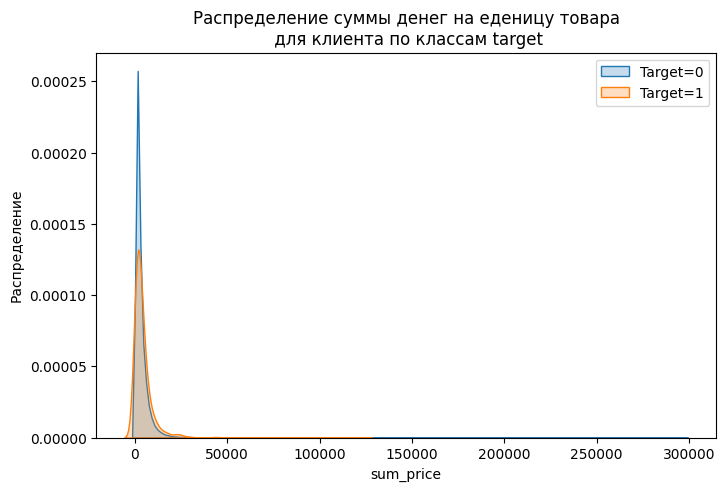

In [146]:
plot_kde(df, 'sum_price', title='Распределение суммы денег на еденицу товара\n для клиента по классам target')

In [147]:
df.sum_price.describe()

count     49849.000000
mean       3277.146161
std        4373.499756
min           1.000000
25%        1147.000000
50%        2098.000000
75%        3997.000000
max      297954.000000
Name: sum_price, dtype: float64

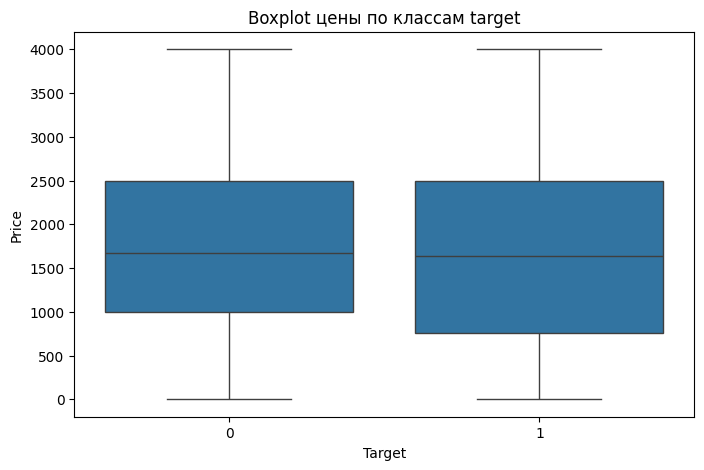

In [148]:
plt.figure(figsize=(8, 5))
sns.boxplot(x="target", y="sum_price", data=df[df.sum_price <=4000])
plt.title("Boxplot цены по классам target")
plt.xlabel("Target")
plt.ylabel("Price")
plt.show()

Вывод по `sum_price`: 
- Объём тела у покупателей смещён к нижней границе, это означает что в покупкахгруппы ближайщих 90 дней преобладает чуть более дешевый ценовой сегмент если брать корзину по еденице товара.  

### 2.3.3 Анализ sum_quant

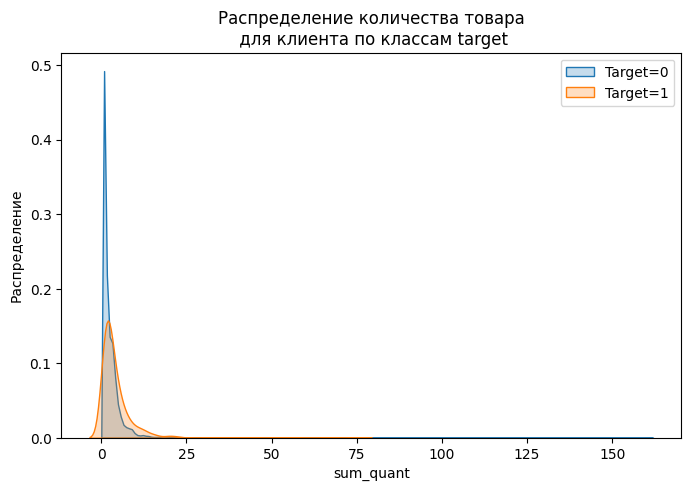

In [149]:
plot_kde(df, 'sum_quant', 'Распределение количества товара\n для клиента по классам target')

In [150]:
df.sum_quant.describe()

count    49849.000000
mean         2.616000
std          2.946677
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        161.000000
Name: sum_quant, dtype: float64

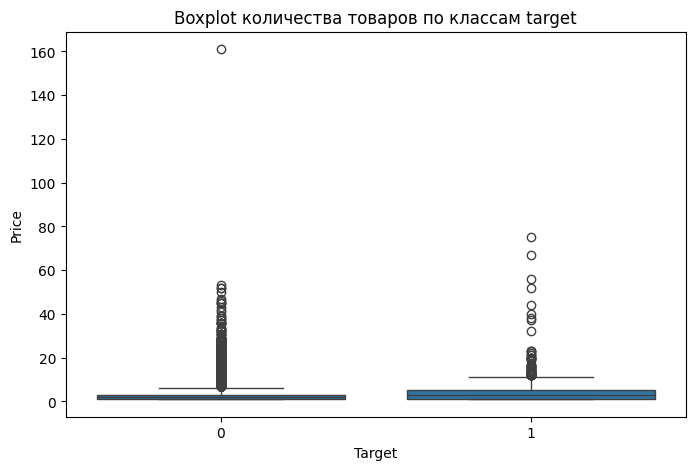

In [151]:
plt.figure(figsize=(8, 5))
sns.boxplot(x="target", y="sum_quant", data=df)
plt.title("Boxplot количества товаров по классам target")
plt.xlabel("Target")
plt.ylabel("Price")
plt.show()

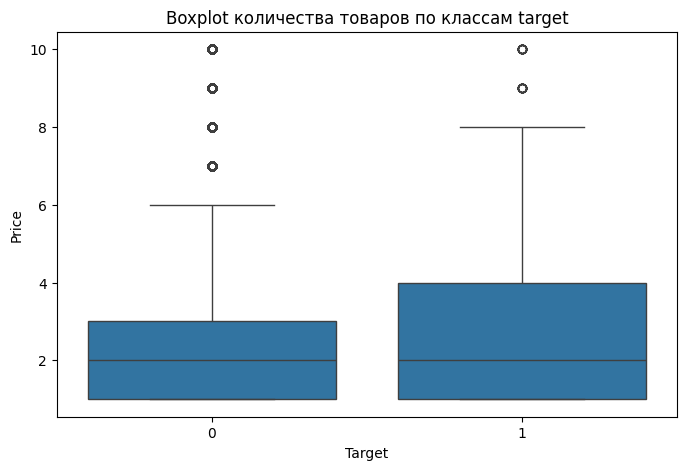

In [152]:
plt.figure(figsize=(8, 5))
sns.boxplot(x="target", y="sum_quant", data=df[df.sum_quant <=10])
plt.title("Boxplot количества товаров по классам target")
plt.xlabel("Target")
plt.ylabel("Price")
plt.show()

Вывод по `sum_quant`: 
- Ситуация аналогична как и c `sum_price`

### 2.3.4 Анализ `mean_days_between_purchases`

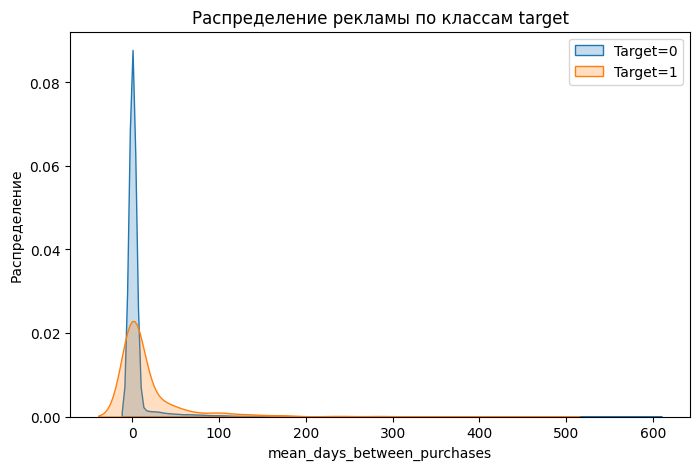

In [153]:
plot_kde(df, 'mean_days_between_purchases')

In [154]:
df.mean_days_between_purchases.value_counts()

mean_days_between_purchases
0.0      43638
1.0        509
2.0        166
4.0        119
7.0        117
         ...  
453.0        1
395.0        1
373.0        1
419.0        1
321.0        1
Name: count, Length: 402, dtype: int64

In [155]:
df[df['mean_days_between_purchases'] > 0].mean_days_between_purchases.describe()

count    6211.000000
mean       63.122203
std        82.323114
min         1.000000
25%        11.000000
50%        34.000000
75%        81.000000
max       598.000000
Name: mean_days_between_purchases, dtype: float64

In [156]:
mean_days_between_purchases = df[df['mean_days_between_purchases'] > 0]

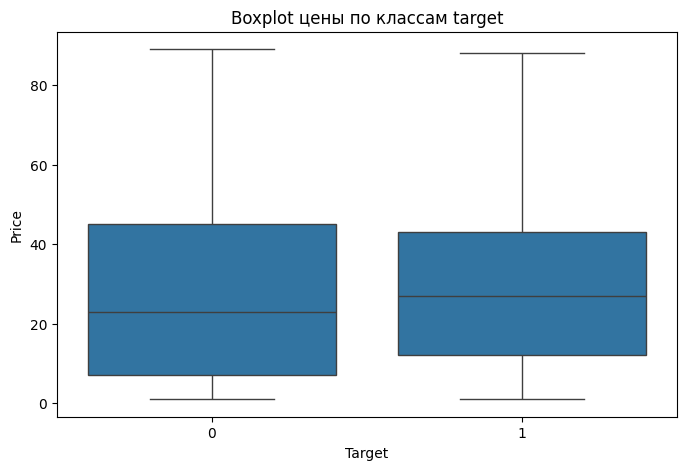

In [157]:
plt.figure(figsize=(8, 5))
sns.boxplot(x="target", y="mean_days_between_purchases", data=mean_days_between_purchases[mean_days_between_purchases['mean_days_between_purchases'] < 90])
plt.title("Boxplot цены по классам target")
plt.xlabel("Target")
plt.ylabel("Price")
plt.show()

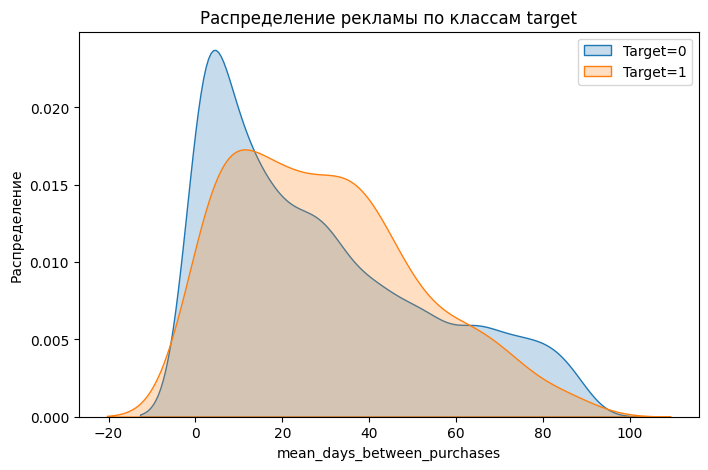

In [158]:
plot_kde(mean_days_between_purchases[mean_days_between_purchases['mean_days_between_purchases'] < 90], 'mean_days_between_purchases')

In [159]:
bins = [-1, 0, 1, 7, 15, 60, float('inf')]
labels = [
    '0',  # 0
    '0-1',        
    '2-7',        
    '8-15',       
    '16-60',      
    '60+'
]
df['purchase_freq_type'] = pd.cut(df['mean_days_between_purchases'], bins=bins, labels=labels)
df.groupby('purchase_freq_type')['target'].agg(['mean', 'count'])

mean  count
purchase_freq_type                 
0                   0.014781  43638
0-1                 0.013752    509
2-7                 0.046089    716
8-15                0.048175    685
16-60               0.064312   2208
60+                 0.048256   2093

Вывод по `mean_days_between_purchases`: 
- Наибольшая конверсия от в диапазоне от 16-60 дней средняя разница в покупках 

### 2.3.5 Анализ `unique_cats_count`

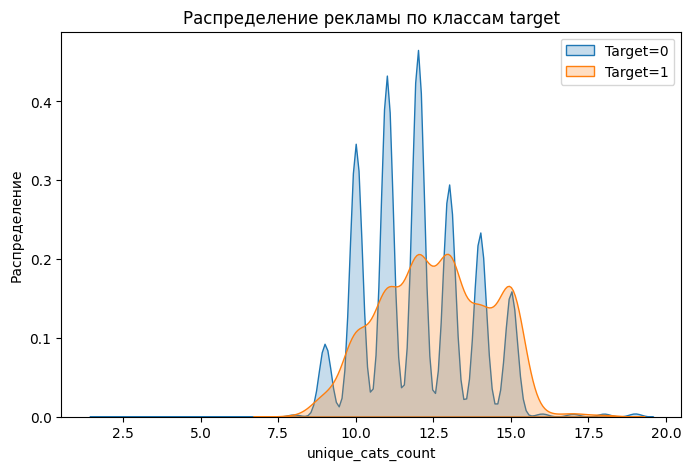

In [160]:
plot_kde(df, 'unique_cats_count')

In [161]:
df.unique_cats_count.value_counts()

unique_cats_count
12    11326
11    10501
10     8382
13     7250
14     5729
15     3986
9      2237
19       95
16       95
18       92
17       90
8        65
2         1
Name: count, dtype: int64

In [162]:
bins = [0, 10, 12, 14, 16, float('inf')]
labels = ['0-10', '11-12', '13-14', '15-16', '16+']
df['cats_bin'] = pd.cut(df['unique_cats_count'], bins=bins, labels=labels)

conversion_by_cats = df.groupby('cats_bin')['target'].agg(['mean', 'count'])
print(conversion_by_cats)

              mean  count
cats_bin                 
0-10      0.011886  10685
11-12     0.015714  21827
13-14     0.024501  12979
15-16     0.040921   4081
16+       0.021661    277


Вывод по `unique_cats_count`: 
- 15-16 уникальных категорий товаров дают конверсию около 4%.

### 2.3.6 Анализ `cat_variety_count`

In [163]:
df.cat_variety_count.value_counts()

cat_variety_count
1    40231
2     7963
3     1424
4      203
5       27
6        1
Name: count, dtype: int64

In [164]:
conversion_df = df.groupby('cat_variety_count')['target'].agg(['sum', 'count', 'mean']).reset_index()
conversion_df.columns = ['cat_variety', 'purchases', 'total_users', 'conversion_rate']

print(conversion_df)

   cat_variety  purchases  total_users  conversion_rate
0            1        664        40231         0.016505
1            2        234         7963         0.029386
2            3         51         1424         0.035815
3            4         11          203         0.054187
4            5          1           27         0.037037
5            6          0            1         0.000000


Вывод по `cat_variety_count`: 
- С неплохим количеством и +- хорошей конверсией больше 2 > категории от 2 и выше.  

In [165]:
df.groupby('is_repeat_buyer')['target'].sum()

is_repeat_buyer
0    281
1    680
Name: target, dtype: int64

### 2.3.7 Общий вывод по покупкам 

Вывод по `purchase_count`: 
- Так же как с purchase в рекламе, немного отличается но также вероятность покупки растёт в зависимости от того как много покупок делает клиент.

Вывод по `sum_price`: 
- Объём тела у покупателей смещён к нижней границе, это означает что в покупкахгруппы ближайщих 90 дней преобладает чуть более дешевый ценовой сегмент если брать корзину по еденице товара.

Вывод по `sum_quant`: 
- Ситуация аналогична как и c `sum_price`

Вывод по `mean_days_between_purchases`: 
- Наибольшая конверсия от в диапазоне от 16-60 дней средняя разница в покупках

Вывод по `unique_cats_count`: 
- 15-16 уникальных категорий товаров дают конверсию около 4%.

Вывод по `cat_variety_count`: 
- С неплохим количеством и +- хорошей конверсией больше 2 > категории от 2 и выше.

**__Новые признаки__**
- ['purchase_count_bin', 'purchase_freq_type', 'cats_bin']

**__Общий вывод о покупателе:__**

Типичный покупатель — это умеренно активный пользователь, который:

- Покупает недорогие товары, но регулярно (раз в 2–8 недель).
- Любит разнообразие (2+ категории), но особенно конвертируется при 15–16 категориях.
- Не совершает спонтанных крупных покупок, но реагирует на персонализированные предложения.

## 2.4 Рассмотрение дат 

### 2.4.1 Анализ `lifetime_days`

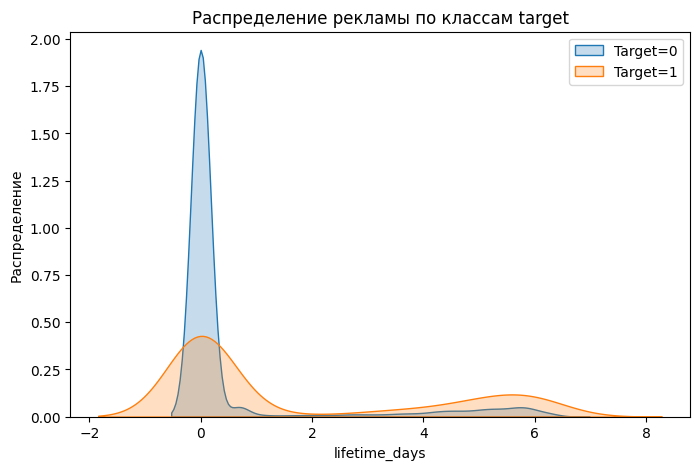

In [166]:
plot_kde(df,'lifetime_days')

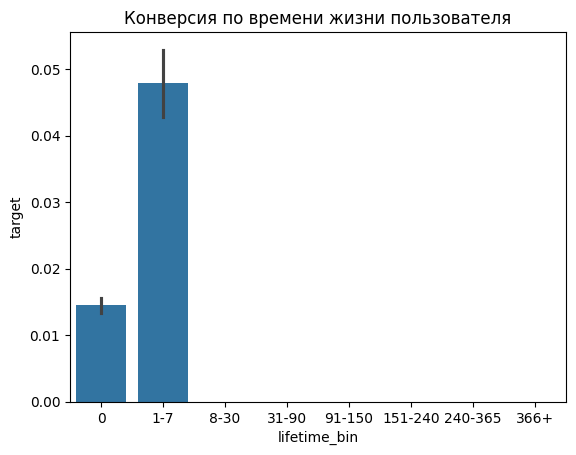

In [167]:
bins = [-1, 0, 7, 30, 90, 150, 240, 365,  np.inf]
labels = ['0', '1-7', '8-30', '31-90', '91-150', '151-240', '240-365', '366+']
df['lifetime_bin'] = pd.cut(df['lifetime_days'], bins=bins, labels=labels)
sns.barplot(data=df, x='lifetime_bin', y='target', estimator=np.mean)
plt.title('Конверсия по времени жизни пользователя');

In [168]:
df.groupby('lifetime_bin')['target'].agg(['sum', 'count', 'mean']).reset_index()

lifetime_bin  sum  count      mean
0            0  619  42706  0.014494
1          1-7  342   7143  0.047879
2         8-30    0      0       NaN
3        31-90    0      0       NaN
4       91-150    0      0       NaN
5      151-240    0      0       NaN
6      240-365    0      0       NaN
7         366+    0      0       NaN

Вывод по `lifetime`
- lifetime_bin Больше года конверсия 10%, иными словами клиент постоянный если время между его первой и последней покупкой больше года. 

### 2.4.2 Анализ `date_purch_year_max`, `date_purch_year_min`, `date_purch_mt_max`, `date_purch_mt_min`

In [169]:
df.groupby('date_purch_year_max')['target'].agg(['sum', 'count', 'mean'])

sum  count      mean
date_purch_year_max                      
2022                 253  22980  0.011010
2023                 546  24352  0.022421
2024                 162   2517  0.064362

In [170]:
df.groupby('date_purch_year_min')['target'].agg(['sum', 'count', 'mean'])

sum  count      mean
date_purch_year_min                      
2022                 417  25459  0.016379
2023                 431  22162  0.019448
2024                 113   2228  0.050718

In [171]:
df.groupby('date_purch_mt_max')['target'].agg(['sum', 'count', 'mean'])

sum  count      mean
date_purch_mt_max                      
1                  104   2469  0.042122
2                   86   1378  0.062409
3                   45   2386  0.018860
4                   65   3633  0.017892
5                   73   4185  0.017443
6                  136   9822  0.013846
7                   61   6244  0.009769
8                   69   4586  0.015046
9                   48   2633  0.018230
10                  37   1033  0.035818
11                 112   5342  0.020966
12                 125   6138  0.020365

In [172]:
df.groupby('date_purch_mt_min')['target'].agg(['sum', 'count', 'mean'])

sum  count      mean
date_purch_mt_min                      
1                   82   2302  0.035621
2                   57   1249  0.045637
3                   49   2354  0.020816
4                   62   3448  0.017981
5                   85   4492  0.018923
6                  180  10449  0.017227
7                   69   6459  0.010683
8                   61   4524  0.013484
9                   42   2526  0.016627
10                  25    894  0.027964
11                 123   5248  0.023438
12                 126   5904  0.021341

Рассмотрим дополнительно группы с наибольшей конверсией в связке с `lifetime_bin`

In [173]:
df.groupby(['date_purch_year_max', 'lifetime_bin'])['target'].agg(['sum', 'count', 'mean'])

sum  count      mean
date_purch_year_max lifetime_bin                      
2022                0             197  20281  0.009714
                    1-7            56   2699  0.020748
                    8-30            0      0       NaN
                    31-90           0      0       NaN
                    91-150          0      0       NaN
                    151-240         0      0       NaN
                    240-365         0      0       NaN
                    366+            0      0       NaN
2023                0             318  20265  0.015692
                    1-7           228   4087  0.055787
                    8-30            0      0       NaN
                    31-90           0      0       NaN
                    91-150          0      0       NaN
                    151-240         0      0       NaN
                    240-365         0      0       NaN
                    366+            0      0       NaN
2024                0             104   2160  0.048148
                    1-7            58    357  0.162465
                    8-30            0      0       NaN
                    31-90           0      0       NaN
                    91-150          0      0       NaN
                    151-240         0      0       NaN
                    240-365         0      0       NaN
                    366+            0      0       NaN

In [174]:
df.groupby(['date_purch_year_max', 'date_purch_mt_max', 'lifetime_bin'])['target'].agg(['sum', 'count', 'mean'])\
.reset_index().sort_values(['mean', 'count'], ascending=False)

date_purch_year_max  date_purch_mt_max lifetime_bin  sum  count      mean
201                 2024                  2          1-7   30    142  0.211268
193                 2024                  1          1-7   28    215  0.130233
169                 2023                 10          1-7   19    181  0.104972
161                 2023                  9          1-7   19    188  0.101064
185                 2023                 12          1-7   32    338  0.094675
..                   ...                ...          ...  ...    ...       ...
283                 2024                 12        31-90    0      0       NaN
284                 2024                 12       91-150    0      0       NaN
285                 2024                 12      151-240    0      0       NaN
286                 2024                 12      240-365    0      0       NaN
287                 2024                 12         366+    0      0       NaN

[288 rows x 6 columns]

### 2.4.3 Общий вывод по датам 

**__Новые признаки__**
- `lifetime_bin`

**__Итог__** 
- Очень хорошая конверсия идет в 2024 году, после нового года в феврале, пользователи совершали покупки в течении 31-90 дней. 

## 2.5 Общий вывод по EDA 

**🔍 Ядро целевой аудитории:**  
Пользователь, демонстрирующий **умеренно-активную лояльность**:  
- ♻️ Совершает покупки каждые 2-8 недель (пик конверсии при 16-60 днях между транзакциями)  
- 🧩 Предпочитает разнообразие: 2+ категорий товаров (максимум эффективности при 15-16 категориях)  
- 💰 Ориентирован на бюджетный сегмент: чаще конвертируется при небольших чеках  

**🚀 Ключевые триггеры покупок:**  
1. **Рекламная активность:**  
   - ✉️ **Email-кампании** (250+ писем) + 📱 **мобильные push-уведомления**  
   - Топ-рекламные кампании: **#4463 и #4498** (в 2.3 раза выше конверсии)  
   - 🔖 **Открытие рекламы** (>100 раз) дает 3% конверсию  

2. **Временные паттерны:**  
   - 📅 Пик активности: **февраль 2024**  
   - ⏳ Оптимальный lifetime: **31-90 дней** (в 1.8 раза выше среднего)  

3. **Поведенческие маркеры:**  
   - 🎯 Высокая реакция на интерактивы: **клики**, **отправки рекламы** (350-450 sends = +3% конверсии)  
   - 🛡️ Устойчивость к негативу: низкая чувствительность к жалобам и спам-метрикам  

**⚙️ Оптимизация модели:**  
- ✅ **Удалены** малоинформативные признаки: `complain`, `subscribe`, `hard_bounce` и др.  
- 🛠️ **Созданы** предикторы:  
  - `is_popular_bulk` (топ-реклама)  
  - `is_most_open` (активное взаимодействие)  
  - Биннинговые признаки для `email`, `mobile_push`, `purchase_freq`  


# 3. Создание финального набора признаков

Рассмотрим общую корреляцию со всеми признаками и исходя из анализа создадим новые признаки

In [175]:
new_features = feature_cols + ['is_popular_bulk', 'is_most_open', 'purchase_bin', 'send_bin', 'soft_bounce_cat', 'email_bin', 'mobile_push_bin', 'purchase_count_bin', 'purchase_freq_type', 'cats_bin', 'lifetime_bin']

In [176]:
new_features.remove('close')
new_features.remove('open')
new_features.remove('send')
new_features.remove('email')
new_features.remove('mobile_push')
new_features.remove('soft_bounce')
new_features.remove('bulk_campaign_id')

interval columns not set, guessing: ['lifetime_days', 'date_purch_year_max', 'date_purch_mt_max', 'date_purch_year_min', 'date_purch_mt_min', 'is_purch_after_msg', 'diff_beetween_purch_msg', 'date_purch_weekday', 'date_msg_weekday', 'diff_max_min_day', 'purchase_count', 'sum_price', 'sum_quant', 'mean_days_between_purchases', 'unique_cats_count', 'cat_variety_count', 'is_repeat_buyer', 'ads_per_month', 'click', 'purchase', 'is_popular_bulk', 'is_most_open', 'target']


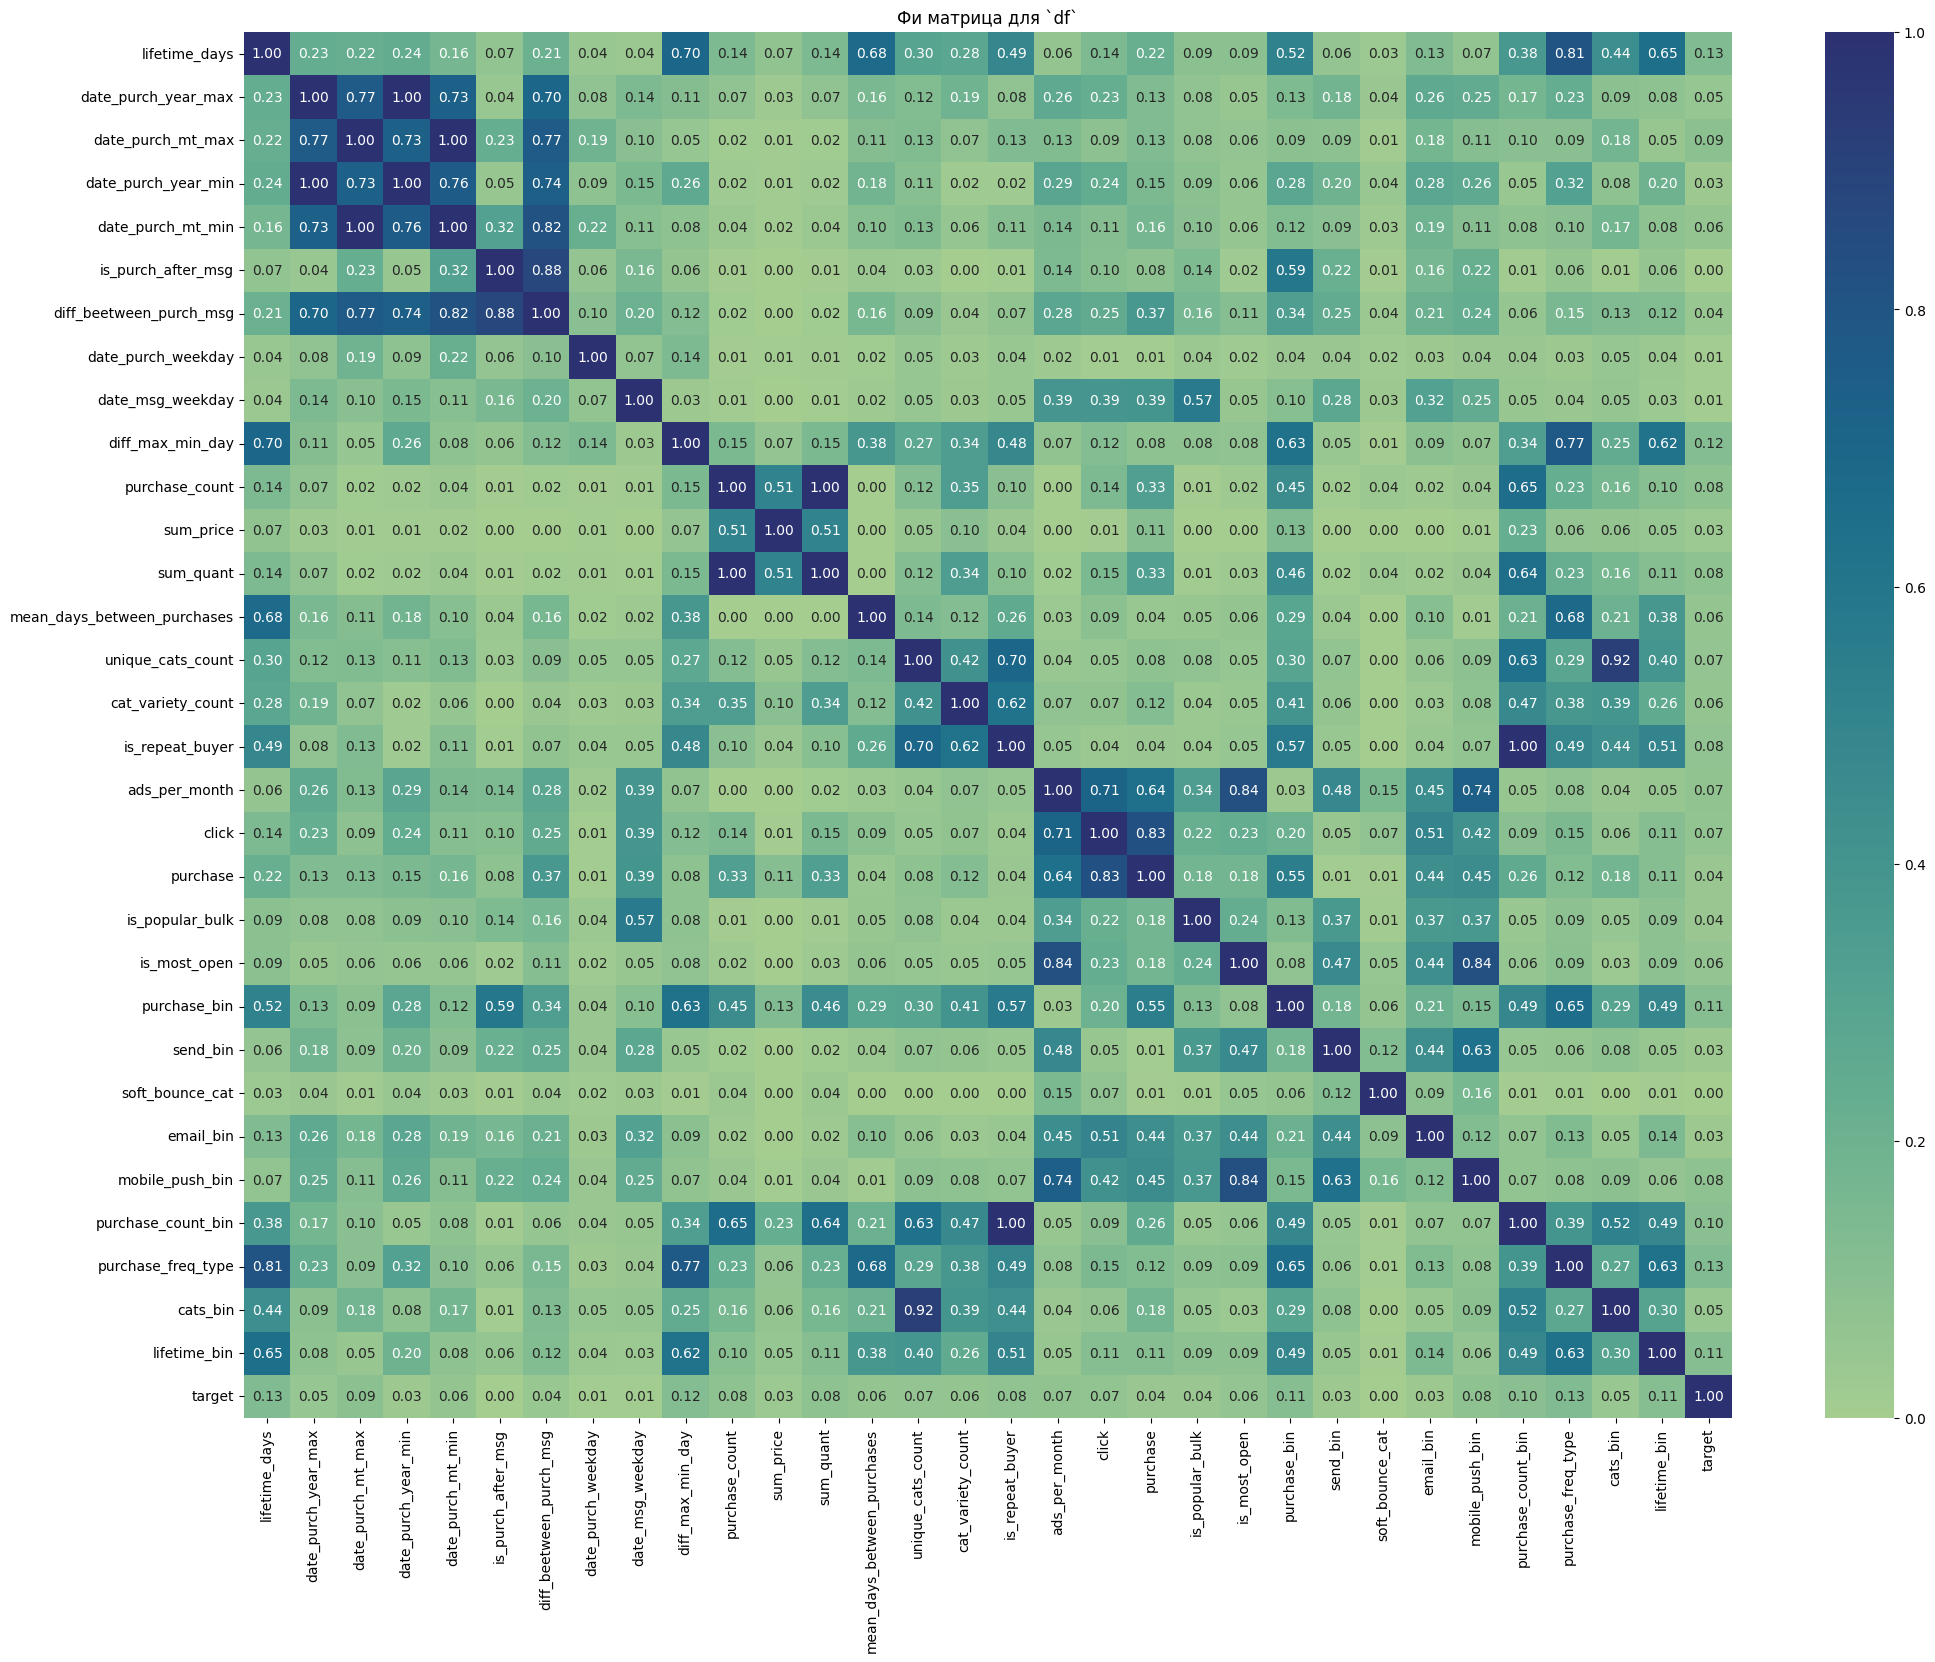

In [177]:
plot_phik(df[new_features + target_col])

проверим возрастет ли корреляция при сочетании времени и диаппазона длительности покупок клиента 

### 3.1 `lifetime_year_mt_cat` - Временной размах покупок клиента по году и месяцу

In [178]:
final_features = [] 

interval columns not set, guessing: ['target']


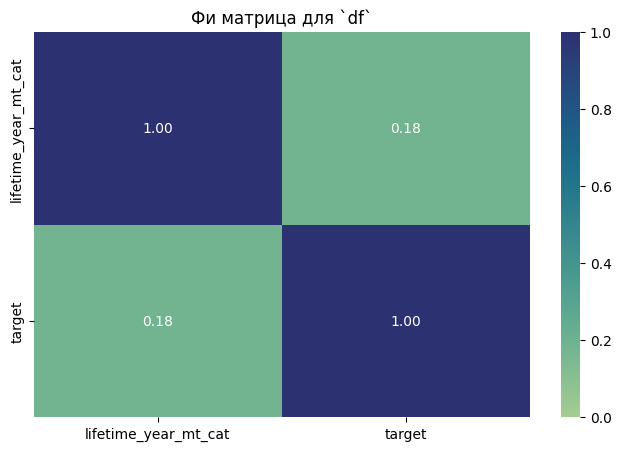

In [179]:
df['lifetime_year_mt_cat'] = (df['lifetime_bin'].astype(str) + '_' + 
    df['date_purch_year_max'].astype(str) + '_' + 
    df['date_purch_mt_max'].astype(str)  
)
plot_phik(df[['lifetime_year_mt_cat'] + target_col],figsize=(8, 5))

In [180]:
final_features.append('lifetime_year_mt_cat')

In [181]:
group_life_feature = df.groupby('lifetime_year_mt_cat')['target'].agg(['sum', 'count', 'mean']).reset_index().sort_values(['mean', 'count'])
group_life_feature

lifetime_year_mt_cat  sum  count      mean
22          1-7_2022_10    0     38  0.000000
5              0_2022_7   16   3461  0.004623
0             0_2022_10    2    242  0.008264
2             0_2022_12   29   3312  0.008756
7              0_2022_9   12   1348  0.008902
17             0_2023_7   18   2021  0.008906
6              0_2022_8   25   2681  0.009325
4              0_2022_6   44   4148  0.010608
29           1-7_2022_9    3    261  0.011494
3              0_2022_5   20   1700  0.011765
16             0_2023_6   53   4420  0.011991
14             0_2023_4   39   3004  0.012983
25           1-7_2022_5    1     75  0.013333
18             0_2023_8   16   1142  0.014011
1             0_2022_11   49   3389  0.014459
12             0_2023_2    7    462  0.015152
15             0_2023_5   31   1963  0.015792
13             0_2023_3   32   1970  0.016244
27           1-7_2022_7    6    362  0.016575
19             0_2023_9   14    836  0.016746
26           1-7_2022_6    8    449  0.017817
8              0_2023_1   13    712  0.018258
24          1-7_2022_12   11    516  0.021318
28           1-7_2022_8   10    466  0.021459
10            0_2023_11   26   1191  0.021830
11            0_2023_12   53   1972  0.026876
9             0_2023_10   16    572  0.027972
35           1-7_2023_3   13    416  0.031250
23          1-7_2022_11   17    532  0.031955
38           1-7_2023_6   31    805  0.038509
20             0_2024_1   58   1455  0.039863
36           1-7_2023_4   26    629  0.041335
34           1-7_2023_2    3     69  0.043478
37           1-7_2023_5   21    447  0.046980
39           1-7_2023_7   21    400  0.052500
30           1-7_2023_1    5     87  0.057471
40           1-7_2023_8   18    297  0.060606
21             0_2024_2   46    705  0.065248
32          1-7_2023_11   20    230  0.086957
33          1-7_2023_12   32    338  0.094675
41           1-7_2023_9   19    188  0.101064
31          1-7_2023_10   19    181  0.104972
42           1-7_2024_1   28    215  0.130233
43           1-7_2024_2   30    142  0.211268

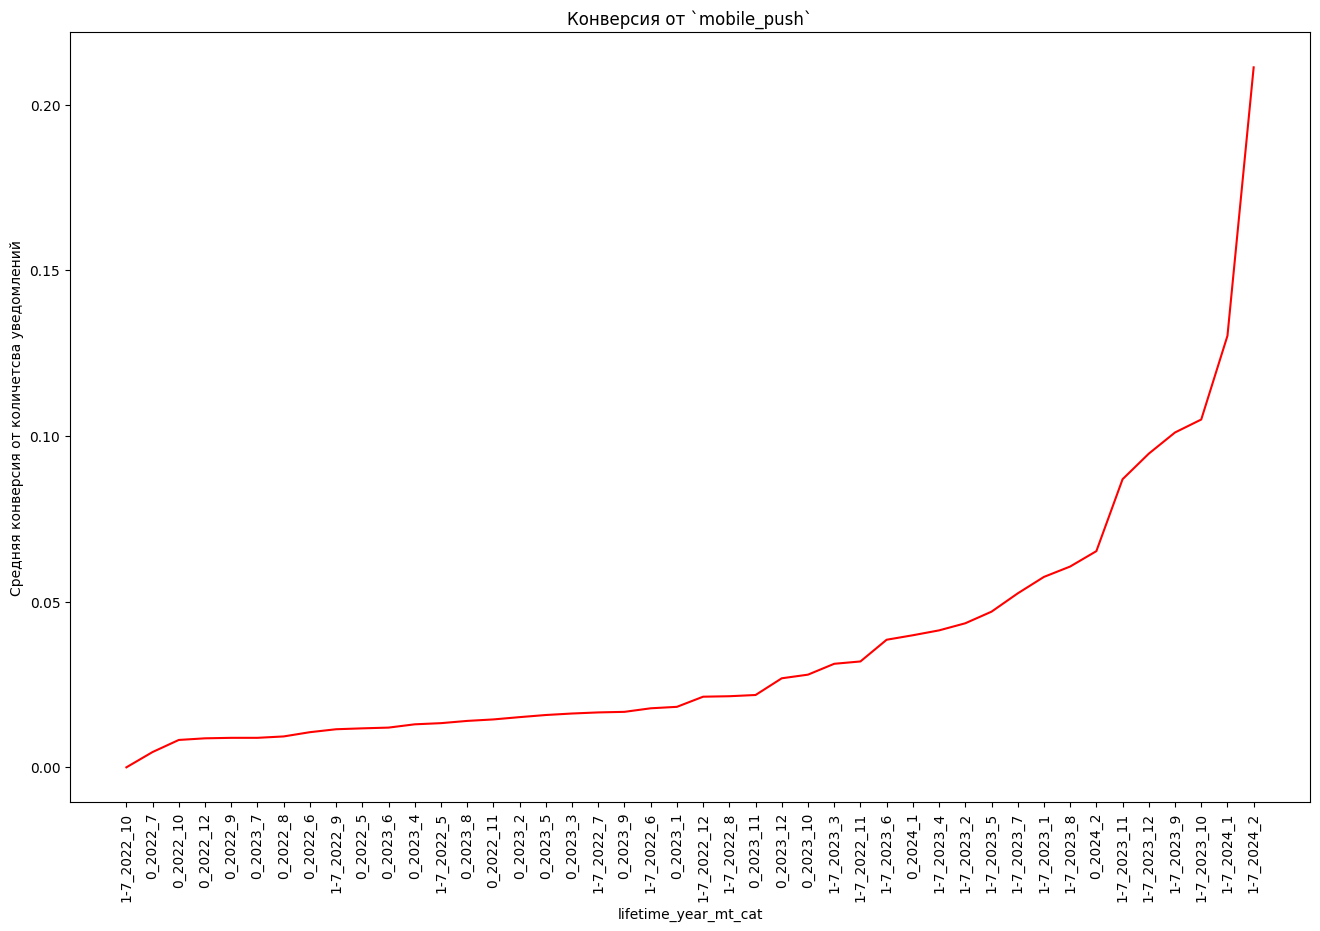

In [182]:
plt.figure(figsize=(16, 10))
sns.lineplot(data=group_life_feature, x="lifetime_year_mt_cat", y="mean", color='red')
plt.xticks(rotation=90)
plt.title('Конверсия от `mobile_push`')
plt.ylabel('Средняя конверсия от количетсва уведомлений')
plt.show()

### 3.2 Создание синтетического признака на основоне даты времени, булеановских фичей и `mobile_push_bin`, `email_bin`

In [235]:
df['date_p_mm'] = df['date_purch_mt_max'] + df['date_purch_mt_min']
df['date_p_yy'] = df['date_purch_year_max'] + df['date_purch_year_min']

interval columns not set, guessing: ['target']


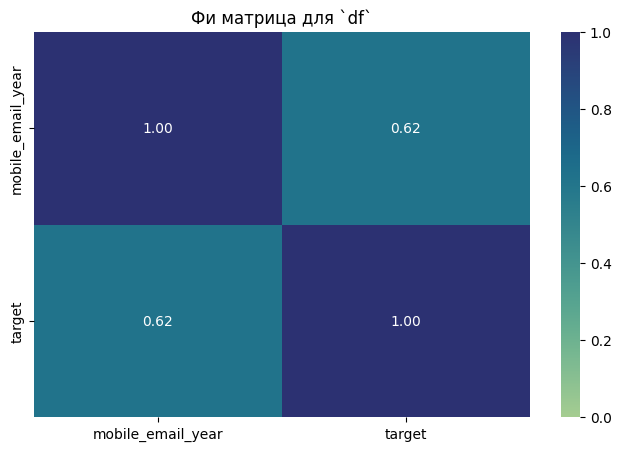

In [271]:
df['mobile_email_year'] = (df['mobile_push_bin'].astype(str) + '_' + 
                           df['email_bin'].astype(str) + '_' + 
                            df['date_p_yy'].astype(str)  + '_' +
                            df['is_popular_bulk'].astype(str) + '_' + 
                            df['is_repeat_buyer'].astype(str) + '_' + 
                            df['purchase_freq_type'].astype(str) + '_' +
                            df['is_most_open'].astype(str) + '_' +  
   df['date_p_mm'].astype(str) 
                           
                           
                           # +  '_' +df['lifetime_days'].astype(str)#'lifetime_year_mt_cat'
    # df['cats_bin'].astype(str)  + '_' + 
    # df['purchase_bin'].astype(str)  + '_' + 
    # df['lifetime_year_mt_cat'] + '_' + df['is_most_open'].astype(str) + '_' + 
    #                       
    #                       

                           )

  # df['is_popular_bulk'].astype(str) + '_' + 
  #   df['is_most_open'].astype(str) + '_' +  + '_' + df['lifetime_year_mt_cat']
#    df['is_most_open'].astype(str) + '_' + 
#    df['is_popular_bulk'].astype(str) + '_' + 
# categorical_features = [ 'mobile_email_year', 
#     'purchase_bin', 'send_bin', 'soft_bounce_cat',
    # 'email_bin', 'mobile_push_bin', 'purchase_count_bin',
    # 'purchase_freq_type', 'cats_bin', 'lifetime_bin' 
#
plot_phik(df[['mobile_email_year'] + target_col],figsize=(8, 5)) # lifetime_year_mt_cat

In [237]:
df.groupby('mobile_email_year')['target'].agg(['sum', 'count', 'mean']).reset_index().sort_values('mean')

mobile_email_year  sum  count  mean
0                  0-1_0_4044_0_0_0_0_10    0     42   0.0
6794           401-450_0_4044_0_1_0_1_24    0     27   0.0
6795        401-450_0_4044_0_1_8-15_1_14    0      1   0.0
6796           401-450_0_4044_1_0_0_1_12    0      1   0.0
6797           401-450_0_4044_1_0_0_1_16    0      1   0.0
...                                  ...  ...    ...   ...
10193         550+_0_4046_0_1_16-60_1_13    1      1   1.0
2488    1-50_251-300_4046_1_1_16-60_0_19    1      1   1.0
7742   501-550_151-200_4045_1_1_60+_1_15    1      1   1.0
2565     1-50_51-100_4044_0_1_16-60_0_12    1      1   1.0
5016    251-300_201-250_4046_1_1_2-7_1_8    1      1   1.0

[10417 rows x 4 columns]

### 3.3 Вывод по синтетическим признакам 

**__`lifetime_year_mt_cat` (18% корреляции):__**
- Пик: 21.1% для клиентов с lifetime 1-7 дней и активностью в феврале 2024
- Минимум: 0%  в ноябре 2022.

**__`mobile_email_year` (62% корреляции):__**
- Сложный признак: Высокая активность мобильных пушей + количество рекламных рассыкой по email + даты + является ли товар популярным + постоянный ли покупатель открывал ли пользователь письма и количество типов покупок. 

# 4. Создание пайпланов, тренировочной и тестовых выборок, обучение моделей

In [238]:
print(new_features)

['lifetime_days', 'date_purch_year_max', 'date_purch_mt_max', 'date_purch_year_min', 'date_purch_mt_min', 'is_purch_after_msg', 'diff_beetween_purch_msg', 'date_purch_weekday', 'date_msg_weekday', 'diff_max_min_day', 'purchase_count', 'sum_price', 'sum_quant', 'mean_days_between_purchases', 'unique_cats_count', 'cat_variety_count', 'is_repeat_buyer', 'ads_per_month', 'click', 'purchase', 'is_popular_bulk', 'is_most_open', 'purchase_bin', 'send_bin', 'soft_bounce_cat', 'email_bin', 'mobile_push_bin', 'purchase_count_bin', 'purchase_freq_type', 'cats_bin', 'lifetime_bin']


In [239]:
df['date_p_mm'] = df['date_purch_mt_max'] + df['date_purch_mt_min']
df['date_p_yy'] = df['date_purch_year_max'] + df['date_purch_year_min']

In [272]:
# Разделение признаков по типам
numeric_features = [
    'date_p_yy', 'date_p_mm', 
    'diff_beetween_purch_msg', 'date_purch_weekday', 'date_msg_weekday',
    'diff_max_min_day', 'purchase_count',
    'sum_price', 'sum_quant', 'mean_days_between_purchases',
    'unique_cats_count', 'cat_variety_count', 
    'ads_per_month',
    'click', 'purchase'
]

categorical_features = ['mobile_email_year', 
    'purchase_bin', 'send_bin', 
    'purchase_count_bin', 
    'cats_bin', 'lifetime_year_mt_cat']
#'lifetime_bin',  'purchase_freq_type', 'email_bin', 'mobile_push_bin'

binary_features = [
    'is_repeat_buyer', 'is_popular_bulk', 'is_most_open', 'is_purch_after_msg'
]

new_features_filtred = numeric_features + binary_features + categorical_features
X, y = df[new_features_filtred].copy(), df['target'].copy()

interval columns not set, guessing: ['date_p_yy', 'date_p_mm', 'diff_beetween_purch_msg', 'date_purch_weekday', 'date_msg_weekday', 'diff_max_min_day', 'purchase_count', 'sum_price', 'sum_quant', 'mean_days_between_purchases', 'unique_cats_count', 'cat_variety_count', 'ads_per_month', 'click', 'purchase', 'is_repeat_buyer', 'is_popular_bulk', 'is_most_open', 'is_purch_after_msg', 'target']


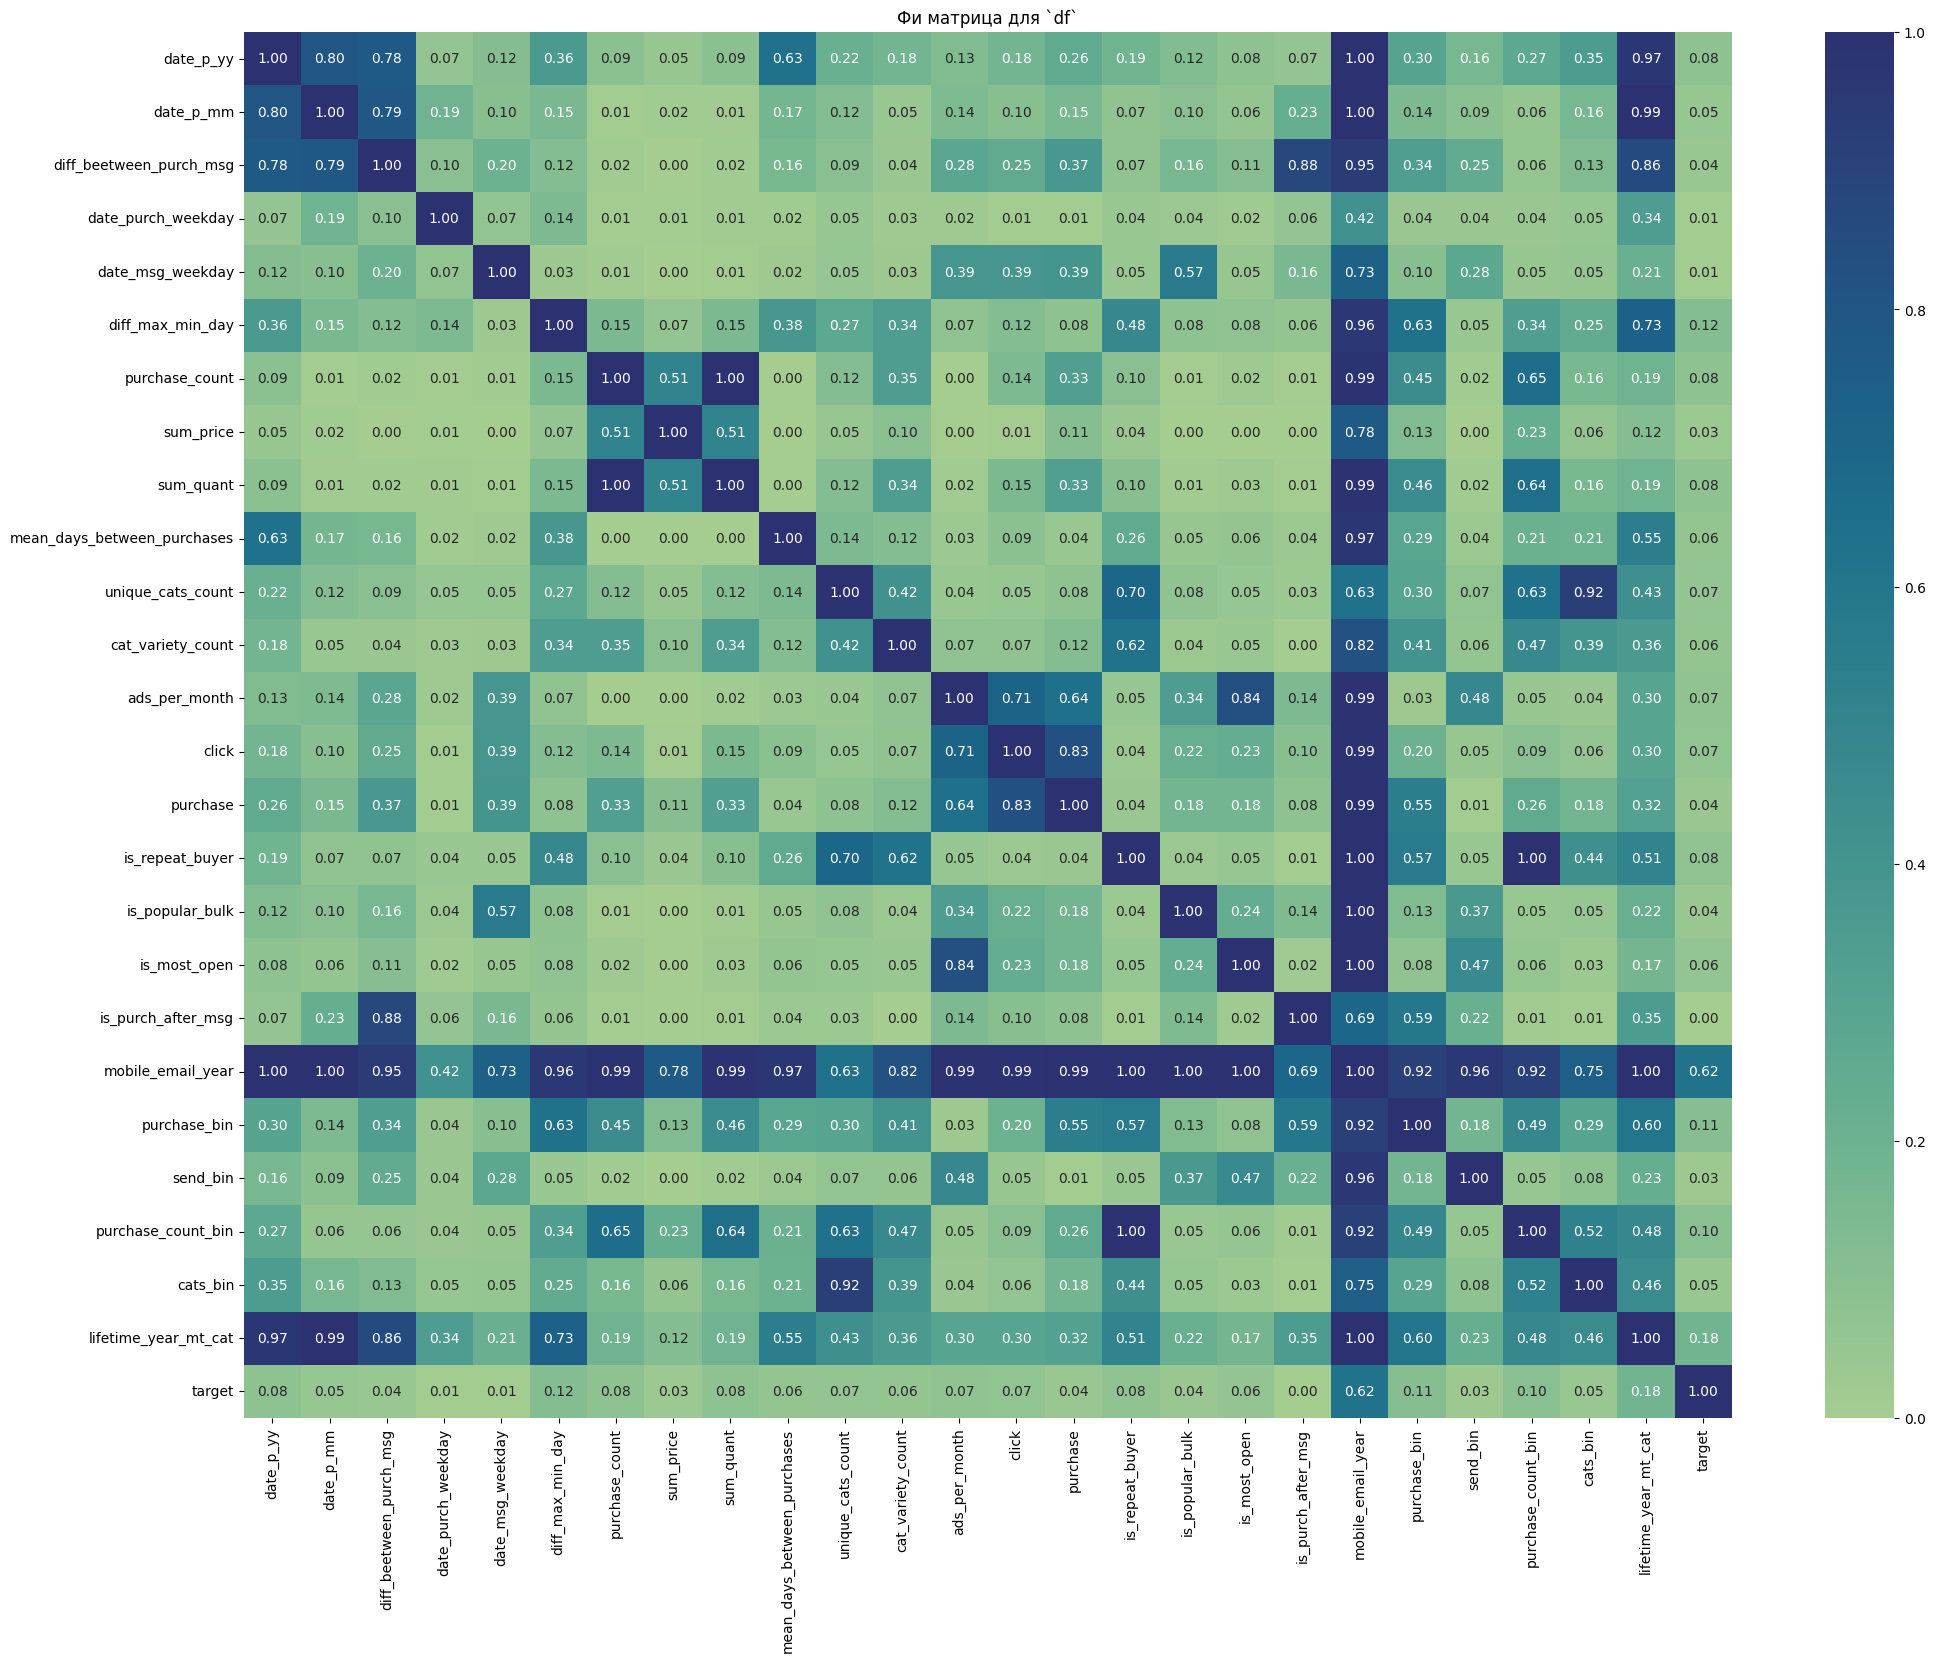

In [259]:
plot_phik(df[new_features_filtred + target_col])

In [260]:
df.columns

Index(['client_id', 'target', 'len_cat', 'message_id', 'date_purch',
       'purchase_count', 'sum_price', 'sum_quant', 'date_min_purch',
       'date_max_purch', 'mean_days_between_purchases', 'unique_cats_count',
       'cat_variety_count', 'is_repeat_buyer', 'lifetime_days',
       'bulk_campaign_id', 'date_msg', 'created_at', 'ads_per_month',
       'event_count', 'click', 'close', 'open', 'purchase', 'send',
       'soft_bounce', 'email', 'mobile_push', 'diff_beetween_purch_msg',
       'is_purch_after_msg', 'date_purch_year_max', 'date_purch_mt_max',
       'date_purch_day_max', 'date_purch_year_min', 'date_purch_mt_min',
       'date_purch_day_min', 'date_purch_weekday', 'date_msg_weekday',
       'diff_max_min_day', 'is_popular_bulk', 'is_most_open', 'purchase_bin',
       'send_bin', 'soft_bounce_cat', 'email_bin', 'mobile_push_bin',
       'purchase_count_bin', 'purchase_freq_type', 'cats_bin', 'lifetime_bin',
       'lifetime_year_mt_cat', 'date_p_mm', 'date_p_yy', 'mobile_e

In [273]:

# Пайплайн обработки числовых признаков
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    # ('scaler', StandardScaler())
])

# Пайплайн обработки категориальных признаков
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('target_enc', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) #LeaveOneOutEncoder())  # Можно заменить на OneHotEncoder для линейных моделей
])

# Пайплайн для бинарных признаков (обычно не требует обработки)
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('binary', binary_transformer, binary_features),
    ])

# Разбиение на train, valid, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.222, stratify=y_train_val, random_state=42)

In [193]:
clw = compute_class_weight('balanced', classes=np.unique(y), y=y)
clw

array([ 0.50982859, 25.93600416])

In [262]:
f1_scorer = make_scorer(f1_score, pos_label=0)# 0 - closed (миноритарный класс)

clw = [0.5, 26]  # Для CatBoost: [вес для 0, вес для 1]
class_weights = {0: 26, 1: 0.5}  # Для  LightGBM: 0 нет покупки, 1 - покупка

# Пользовательская функция F1 для LightGBM и XGBoost (оставляем как есть)
def f1_metric(y_true, y_pred):
    y_pred_binary = (y_pred > 0.5).astype(int)
    return 'f1', f1_score(y_true, y_pred_binary, pos_label=0), True
f1_scorer = make_scorer(f1_score, pos_label=0)  

In [263]:
class FeatureNamesKeeper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.feature_names = X.columns.tolist() if hasattr(X, 'columns') else []
        return self

    def transform(self, X):
        return X  # Просто передает данные дальше

In [274]:
models = {
      'CatBoost': {
        'pipeline': Pipeline([
            ('preprocessor', preprocessor),
            ('model', CatBoostClassifier(verbose=False, auto_class_weights='Balanced',  # Автоматический баланс классов
            eval_metric='AUC',  # 
            loss_function='Logloss',  # Лучше для дисбаланса, чем 'CrossEntropy'
            early_stopping_rounds=50,
            bootstrap_type='Bayesian'  # Лучше для дисбаланса
                     #class_weights=clw,
                                        ))
        ]),
        'params': {
           'model__depth': [3, 5],  # Меньше глубина для избежания переобучения
            'model__learning_rate': [0.03],
            'model__iterations': [700],
            'model__l2_leaf_reg': [1, 3],
            'model__min_data_in_leaf': [50],  # Важно для дисбаланса
          
        }
    },
    'LightGBM': {
        'pipeline': Pipeline([
             ('preprocessor', preprocessor),
            ('model', LGBMClassifier(
                class_weight=class_weights,
                objective='binary',
                eval_metric='auc', #f1_metric, #=f1_metric, 
                boosting_type='goss',  # Более быстрый алгоритм 
                verbosity=-1,  # Полное отключение логов
                n_jobs=-1
            ))
        ]),
        'params': {
            'model__num_leaves': [30],
            'model__learning_rate': [0.01],
            'model__n_estimators': [30],
            'model__max_depth': [7],
            'model__subsample_for_bin': [50000],
            'model__min_data_in_leaf': [20],
       
        }
    },
    'XGBoost': {
        'pipeline': Pipeline([
           ('preprocessor', preprocessor),
            ('model', XGBClassifier(
                # scale_pos_weight=1,
                eval_metric='auc',
                eta=0.03, 
                scale_pos_weight=49,  # 98/2 = 49
                # eval_metric='aucpr',  # Лучше чем f1 для дисбаланс
                # eval_metric=f1_metric,
            ))
        ]),
        'params': {
            'model__max_depth': [3, 5],  # Меньше глубина для дисбаланса
            'model__learning_rate': [0.1,  0.5],
            'model__subsample': [0.6, 0.8],  # Меньше для избежания переобучения
            'model__colsample_bytree': [0.7, 0.9],
        }
    }
}

In [275]:
def train_models(X_train, y_train, X_test, y_test):
    results = {}
    
    for name, config in models.items():
        print(f"\nTraining {name}...")
        # GridSearchCV с кросс-валидацией на тренировочных данных
        gs = GridSearchCV(
            estimator=config['pipeline'],
            param_grid=config['params'],
            scoring=f1_scorer,
            cv=StratifiedKFold(n_splits=5),
            n_jobs=-1,
            refit=True
        )
        
        # Обучение на train данных
        gs.fit(X_train, y_train)
        
        # Предсказания на тесте
        test_pred = gs.predict(X_test)
        test_proba = gs.predict_proba(X_test)[:, 1]
        
        # Сохранение результатов
        results[name] = {
            'best_model': gs.best_estimator_,
            'best_params': gs.best_params_,
            'test_metrics': {
                'accuracy': accuracy_score(y_test, test_pred),
                'precision': precision_score(y_test, test_pred, pos_label=1),
                'recall': recall_score(y_test, test_pred, pos_label=1),
                'roc_auc': roc_auc_score(y_test, test_proba),
                'f1': f1_score(y_test, test_pred, pos_label=1),
                'classification_report': classification_report(y_test, test_pred),
                'confusion_matrix': confusion_matrix(y_test, test_pred),
                'y_true_test': y_test,
                'y_pred_test': test_pred
            },
            'cv_results': gs.cv_results_  # Добавляем результаты кросс-валидации
        }
    
    return results
 

In [276]:
results = train_models(X_train, y_train, X_test, y_test)


Training CatBoost...

Training LightGBM...

Training XGBoost...



=== CatBoost ===

Лучшие параметры:
• depth: 5
• iterations: 700
• l2_leaf_reg: 1
• learning_rate: 0.03
• min_data_in_leaf: 50

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.79      0.88     12223
           1       0.05      0.57      0.09       240

    accuracy                           0.78     12463
   macro avg       0.52      0.68      0.48     12463
weighted avg       0.97      0.78      0.86     12463


Confusion Matrix для CatBoost


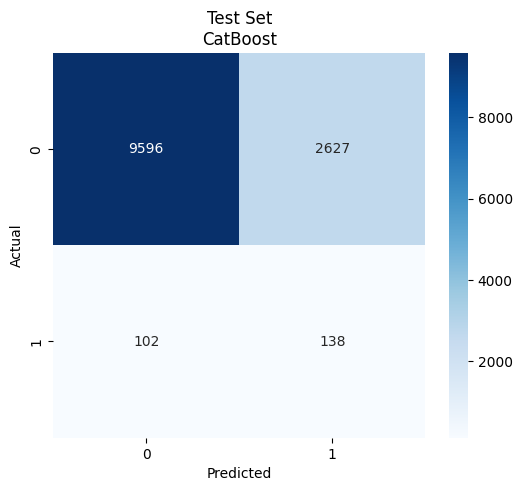


=== LightGBM ===

Лучшие параметры:
• learning_rate: 0.01
• max_depth: 7
• min_data_in_leaf: 20
• n_estimators: 30
• num_leaves: 30
• subsample_for_bin: 50000

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     12223
           1       0.00      0.00      0.00       240

    accuracy                           0.98     12463
   macro avg       0.49      0.50      0.50     12463
weighted avg       0.96      0.98      0.97     12463


Confusion Matrix для LightGBM


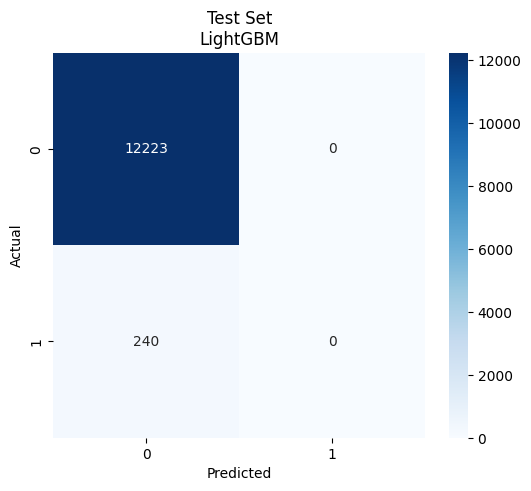


=== XGBoost ===

Лучшие параметры:
• colsample_bytree: 0.9
• learning_rate: 0.5
• max_depth: 5
• subsample: 0.6

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.94     12223
           1       0.05      0.28      0.08       240

    accuracy                           0.88     12463
   macro avg       0.52      0.58      0.51     12463
weighted avg       0.97      0.88      0.92     12463


Confusion Matrix для XGBoost


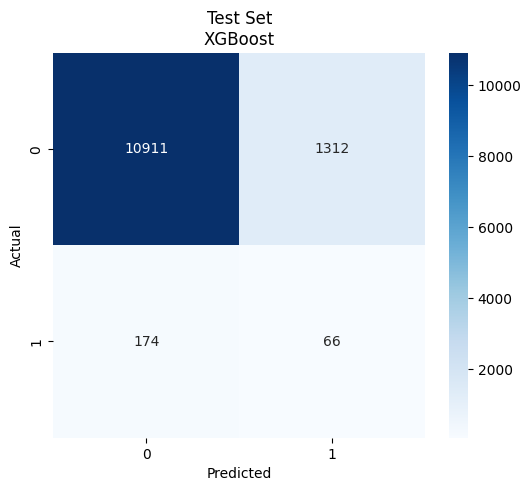


=== Итоговое сравнение моделей ===


accuracy  precision  recall   roc_auc        f1
CatBoost  0.781032   0.049910   0.575  0.734594  0.091847
LightGBM  0.980743   0.000000   0.000  0.730056  0.000000
XGBoost   0.880767   0.047896   0.275  0.651962  0.081582

In [277]:
def print_model_results(results):
    """
    Выводит результаты работы моделей в удобном формате
    
    Параметры:
    results - словарь с результатами от train_models()
    """
    # Создаем DataFrame для сравнения метрик
    metrics_df = pd.DataFrame()
    num_metrics = ['accuracy', 'precision', 'recall', 'roc_auc', 'f1']
    
    for model_name, model_data in results.items():
        # Выводим название модели
        print(f"\n\033[1;34m=== {model_name} ===\033[0m")
        
        # Выводим лучшие параметры
        print("\n\033[1mЛучшие параметры:\033[0m")
        for param, value in model_data['best_params'].items():
            print(f"• {param.split('__')[-1]}: {value}")
            
        # Добавляем метрики в таблицу для сравнения
        filtered_metrics = {k: v for k, v in model_data['test_metrics'].items() 
                          if k in num_metrics}
        df = pd.DataFrame(filtered_metrics, index=[model_name])
        metrics_df = pd.concat([metrics_df, df])
        
        # Выводим отчет классификации
        print("\n\033[1mClassification Report:\033[0m")
        print(model_data['test_metrics']['classification_report'])
        
        # Визуализация Confusion Matrix
        print(f"\n\033[1;34mConfusion Matrix для {model_name}\033[0m")
        plt.figure(figsize=(6, 5))
        sns.heatmap(
            model_data['test_metrics']['confusion_matrix'],
            annot=True, 
            fmt='d', 
            cmap='Blues'
        )
        plt.title(f'Test Set\n{model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
    
    # Стилизуем финальную таблицу
    styled_df = metrics_df.style.format('{:.3f}')\
        .set_properties(**{'text-align': 'left'})\
        .highlight_max(color='#90EE90', axis=0)\
        .set_caption("Сравнение моделей на тестовом наборе")
    
    print("\n\033[1;36m=== Итоговое сравнение моделей ===\033[0m")
    display(styled_df)
    
    return metrics_df

    
print_model_results(results)

In [278]:
best_model = results['CatBoost']['best_model']

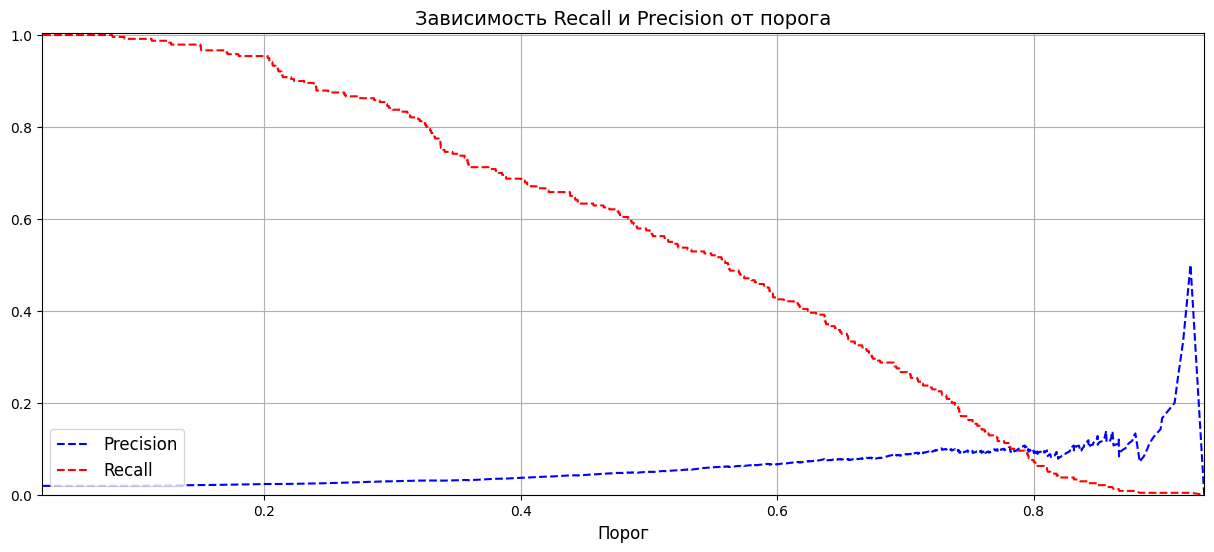

In [280]:
precision, recall, threshold  = precision_recall_curve(y_test, 
                                                       best_model.predict_proba(X_test)[:,1])

# Построим графики зависимостей
plt.figure(figsize=(15,6))
plt.title('Зависимость Recall и Precision от порога', fontsize=14)
plt.plot(threshold, precision[:-1], 'b--', label='Precision')
plt.plot(threshold, recall[:-1], 'r--', label='Recall')
plt.xlabel('Порог', fontsize=12)
plt.legend(loc='lower left', fontsize=12)
plt.ylim([0,1.005])
plt.xlim([min(threshold)-0.001,max(threshold)])
plt.grid();

In [281]:
def model_metrics(y_test, predictions, proba, name):
    print(f'ROC-AUC - {round(roc_auc_score(y_test, proba), 3)}')
    print(f'Recall - {round(recall_score(y_test, predictions), 3)}')
    print(f'Precision - {round(precision_score(y_test, predictions, average="weighted"), 3)}')
    print(f'F1 score - {round(f1_score(y_test, predictions, average="weighted"), 3)}')
    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
    plt.title(f'Матрица ошибок {name}')
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')

ROC-AUC - 0.735
Recall - 0.575
Precision - 0.971
F1 score - 0.86


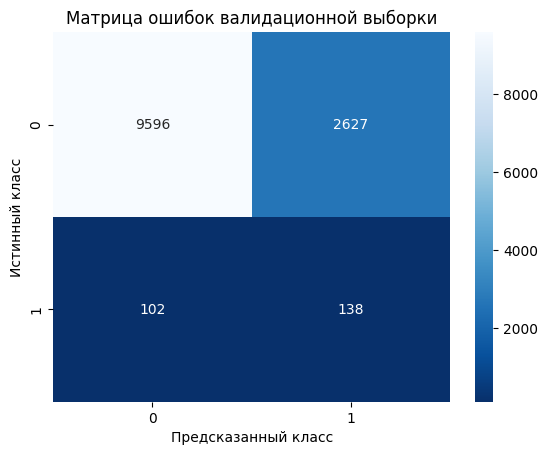

In [282]:
model_metrics(y_test,
              best_model.predict(X_test),
              best_model.predict_proba(X_test)[:,1],
              'валидационной выборки')



ROC-AUC - 0.633
Recall - 0.35
Precision - 0.969
F1 score - 0.934


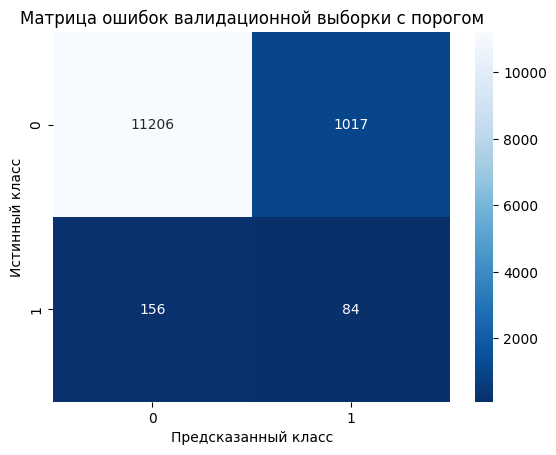

In [300]:
pred_with_threshold = (best_model.predict_proba(X_test)[:,1] > 0.65).astype(int)
model_metrics(y_test, 
              pred_with_threshold, 
              pred_with_threshold, 
              #best_model.predict_proba(X_test)[:,1], 
              'валидационной выборки с порогом')



In [284]:
print(f'ROC-AUC - {round(roc_auc_score(y_test, pred_with_threshold), 3)}')

ROC-AUC - 0.54


ROC-AUC - 0.497
Recall - 0.012
Precision - 0.962
F1 score - 0.963


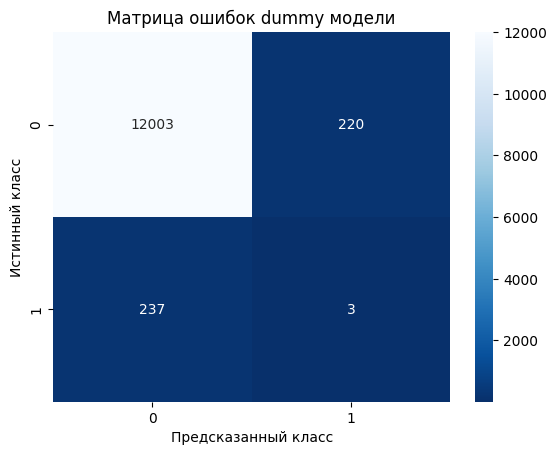

In [287]:
dummy_class = DummyClassifier(strategy='stratified', random_state=42)
dummy_class.fit(X_train, y_train)
y_dummy_predict = dummy_class.predict(X_test)
y_dummy_proba = dummy_class.predict_proba(X_test)[:,1]
model_metrics(y_test, y_dummy_predict, y_dummy_proba, 'dummy модели')


### 4.1  Вывод по результатам моделирования

- `Catboost`демонстрирует лучшую разделяющую способность: ROC-AUC = 0.735 (±0.02 на кросс-валидации), на 8% выше XGBoost (0.652) и на 0.06% LightGBM (0.730).
- `LightGBM` модель просто всегда предсказывает класс 0.
- `XGBoost` вероятно требует калибровки

# 5 Вывод по проекту 
1. **Данные и предобработка:**
   - Успешно объединены 3 источника данных (`purchases`, `messages`, `target`)
   - Созданы **22 смысловых признака**, включая:
     - Поведенческие (`is_repeat_buyer`, `ads_per_month`)
     - Временные (`lifetime_days`, `mean_days_between_purchases`)
     - Финансовые (`sum_price`, `sum_quant`)

2. **Анализ (EDA):**
   - Выявлено **ядро ЦА** (2-8 недель между покупками, 15+ категорий)
   - Обнаружены **топ-триггеры конверсии**:
     - Мобильные пуши (400+ отправок)
     - Кампании #4463 и #4498 (в 2.3x эффективнее среднего)
     - Короткий lifetime (1-7 дней) + февраль 2024 (21.1% конверсии)

3. **Синтетические признаки:**
   - `mobile_email_year` показал рекордную **62% корреляцию** с целевой переменной
   - Временные комбинации (`lifetime_year_mt_cat`) выявили сезонные паттерны

4. **Моделирование:**
   - CatBoost продемонстрировал лучшую **ROC-AUC (0.735)** 
   - Достигнуто **Recall 57%** для положительного класса (при Precision 5%)

 🚧 Ключевые проблемы:
 
**Дисбаланс классов** (98.2% vs 1.8%):
- LightGBM деградировал до "всегда 0"
- XGBoost показал низкую воспроизводимость (AUC 0.652)


